# Imports

In [3]:
import uproot4
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas

# File I/O

In [4]:
root = uproot4.concatenate("combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

# Analysis

First we can mask for valid events based on `fTriggerBits = 65, 67`

`TrigMask` returns an array of indices within `root` which correspond to valid hits based on the trigger we are selecting for. This means when looping over `root`, we only use the indices given in the returned array.

In [3]:
def TrigMask(root, bit1=65, bit2=67):
    '''Returns list of indices of valid events based on triggerBits'''
    validEvents = []
    for i in range(len(root)):
        if (root[i]["fTriggerBits"] == bit1) or (root[i]["fTriggerBits"] == bit2):
            validEvents.append(i)
    return validEvents

BROKEN ________________________________________________________

In [4]:
def get_hits(root):
    # get indices of valid events based on random trigger
    indices = TrigMask(root)
    #print(len(indices))

    # counter - checks the number of valid events in which flag criteria met
    count = 0
    
    for index in indices:   # loop thru all valid events
        # get the detectorIDs and positions of hits in the valid event
        validEvent_ID = root[index]["fAllHits"].detectorID
        validEvent_pos = root[index]["fAllHits"].pos
        
        # debug - check they're the same length
        assert(len(validEvent_ID)==len(validEvent_pos))
        #print(len(validEvent_ID))
        
        # get length of array (corresponds to #hits in valid event)
        numHits = len(validEvent_ID)
        

        # loop thru all hits in the valid event
        st_flag = False
        while not st_flag:
            for i in range(numHits):
                if ((validEvent_ID[i] == 31) or (validEvent_ID[i] == 32)) and ((validEvent_pos[i] >= -21) and (validEvent_pos[i] <= 21)):
                    st_flag = True
                    count += 1
                    print("station1 flagging criteria met")
                
    print(count)
    

In [5]:
get_hits(root)

KeyboardInterrupt: 

**Trying again:** 

In [6]:
detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

In [7]:
def st1_mask(root):
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67) | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)   # hits now masked by trigger
    
    # get the mask of 
    

In [8]:
st1_mask(root)

In [9]:
a = {}
a['test'] = 3

In [10]:
a

{'test': 3}

In [11]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2)
    
    # testing masking for both detID and pos
    mask = mask & (arr.pos >= -21)
    mask = mask & (arr.pos <= 21)

    return mask

def detectorSelection(arr, detid):
    mask = (arr.detectorID== detid)
    return mask

# build detector mask
def detectorMask(arr):
    detmask = {}
    for key,item in detID_dict.items():
        for keyd,det in item['det'].items():
            if len(det)==1:
                detmask[keyd] = detectorSelection(arr,det[0])
            else:
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    return detmask

detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

def get_data_2017(root):
    '''
    returns a list of histogram information
    '''
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    detmask = detectorMask(allhits)
    
    # hit/event rate acquired by dividing by nevents
    nevents = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))
    
    # store hists
    xs = []
    
    for dets,item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            maskedhits_det = maskedhits[detmask[det]]
            numpos = ak.num(maskedhits_det.pos)
            
            xs.append(ak.flatten(maskedhits_det.pos))   # these will be plotted
            
    return xs, nevents

In [12]:
xs, n = get_data_2017(root)

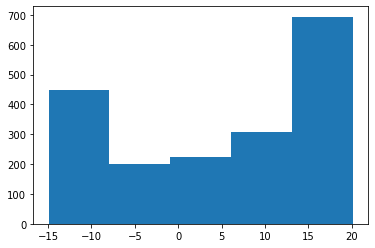

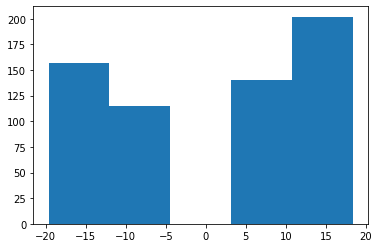

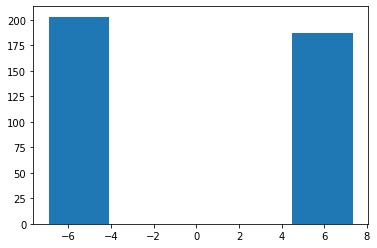

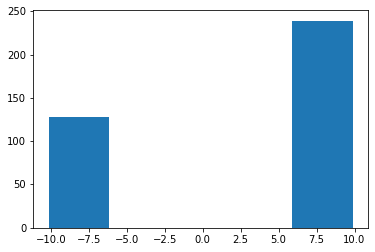

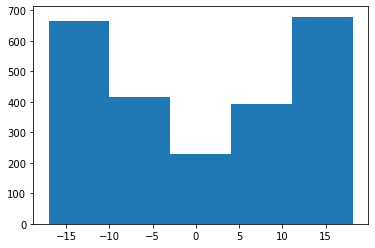

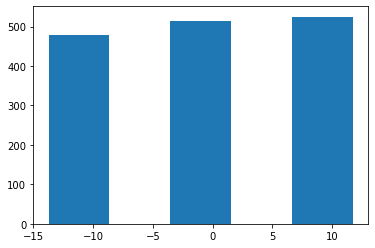

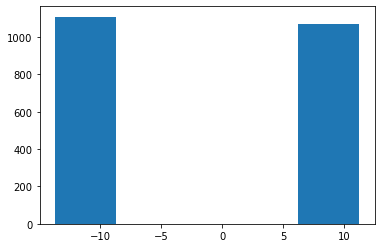

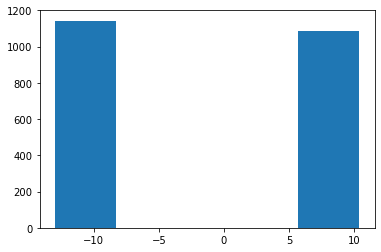

In [48]:
for i in range(len(xs)):
    plt.clf()
    plt.hist(xs[i],bins=5)
    plt.show()

This just plots the 2017 data, but with a cut made. 

# trying to plot via index

Instead, what we need to do is run the original plotting routine **BUT** now include a separate mask which selects for detID and positions relevant for each detector first (based on geometry), and only plot if the criteria is met. The masks will look like:

* **ST1 Mask:** `detID = 31, 32`, `pos = [-14,14]`
* **ST2 Mask:** `detID = 37, 38`, `pos = [-14,14]`
* **ST3 Mask:** `detID = 39, 40`, `pos = [-15,15]`

First, the code checks if there are any hits based on the criteria selected for in the station 1 mask. If yes, then plot stations 2, 3, 4 - else skip (per event). 

Sequential checking should be performed as well, i.e. If station 1 mask meets criteria, then plot station 2. If station 2 mask meets criteria, plot station 3. If station 3 mask meets criteria, plot station 4.

**Helper functions**

In [72]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def stationMask(arr, detid1, detid2, pos1=-15, pos2=15):
    '''
    Mask the hits based on detid and position to set flags
    the position range goes pos1 <= pos <= pos2 -> [pos1,pos2]
    ST1, ST2 use pos [-14,14] -> two panels on either side x=0
    ST3 uses pos [-15,15] -> one panel on either side x = 0
    '''
    # mask on detectorID
    mask = (arr.detectorID >= detid1) & (arr.detectorID <= detid2)
    # mask on position
    mask = mask & (arr.pos >= pos1)
    mask = mask & (arr.pos <= pos2)
    
    return mask
    
# build detector mask
def detectorMask(arr,level=1):
    '''
    Mask based on detectorID (plotting all) or
    Mask based on detectorID and pos (for making cut criteria)
    0 = cut
    1 = all
    '''
    detmask = {}
    if (level == 1):   # get all detectors (used for plotting all)
        for key,item in detID_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    elif (level == 0):   # get only BT detectors (used for selection criteria)
        for key,item in sel_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = stationMask(arr,det[0],det[1])
    else:
        print("invalid level")
    return detmask

detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

In [73]:
# selection dicts -> run stationMask() on this

sel_dict = {'BT':{'dir':'x',
                  'det':{'H1BT':[31,32],
                         'H2BT':[37,38],
                         'H3BT':[39,40],
                         'H4BT':[45,46]                      
                        }
    
                  }
            }

**Plotting**

In [76]:
def flag(dictionary,station=1):
    '''
    looks for the criteria and flags for valid events
    Pass it the selection dictionary, and max station to check
    returns the indices of valid events based on criteria used to create the passed dict
    '''
    nevents = len(dictionary['H1BT'])   # could have used any detector - all have same num of events
    
    indices = np.array([])
    
    if (station == 1):
        for i in range(nevents):   # loop thru all events to look for valid events
            if (ak.sum(dictionary['H1BT'][i]) != 0):   # the event has enough hits that meet the criteria
                indices = np.append(indices,i)
            else:
                pass
    else:
        print("not implemented further stations yet")
    
    return indices

**check to see if this scanning criteria does anything. running `flag()` on det_mask should yield an indices array with length 677. running `flag()` on st1_mask might result in a smaller array. (if not, alter the positions in `stationMask()`**

In [77]:
trigmask = (root.fTriggerBits==65) | (root.fTriggerBits==67)
allhits = root.fAllHits
st1_mask = detectorMask(allhits,0)
det_mask = detectorMask(allhits,1)

cut = flag(st1_mask)
nocut = flag(det_mask)

print("cut: {}\n".format(len(cut)))
print("no cut: {}\n".format(len(nocut)))

cut: 56613

no cut: 159373



As expected, there is a significantly reduced number of valid hits when selecting based on the criteria imposed by the station 1 cut. This number would further decrease if we imposed sequential flagging (i.e. only accept st2 if st1 criteria met, and so on)

**ACTUALLY**

We might not want the indices, and instead a boolean array which we can then overlay with `ak.mask()`

This way we only plot the valid events selected for by criteria - i.e. we run something like

```
final_selection = ak.mask(maskedhits, cut_hits)
```

where `maskedhits` are the hits masked by valid trigger and `cut_hits` are the hits masked by valid criteria

**INSTEAD:** we will have `detectorMask()` use the same `detID_dict` for both cases and cut on the same positions for BT and LR (since the dimensions are the same in x and y for any given BT/LR detector pair)

Then, `flags()` can go through the two dictionaries resulting from `detectorMask()` and use logical and (`&`) to produce a dictionary that is only the intersection of the two dictionaries (from cut, and from allhits)

# Trying to intersect dictionaries

In [79]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def stationMask(arr, detid1, detid2, pos1=-15, pos2=15):
    '''
    Mask the hits based on detid and position to set flags
    the position range goes pos1 <= pos <= pos2 -> [pos1,pos2]
    ST1, ST2 use pos [-14,14] -> two panels on either side x=0
    ST3 uses pos [-15,15] -> one panel on either side x = 0
    '''
    # mask on detectorID
    mask = (arr.detectorID >= detid1) & (arr.detectorID <= detid2)
    # mask on position
    mask = mask & (arr.pos >= pos1)
    mask = mask & (arr.pos <= pos2)
    
    return mask
    
# build detector mask
def detectorMask(arr,level=1):
    '''
    Mask based on detectorID (plotting all) or
    Mask based on detectorID and pos (for making cut criteria)
    0 = cut
    1 = all
    '''
    detmask = {}
    if (level == 1):   # get all detectors (used for plotting all)
        for key,item in detID_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    elif (level == 0):   # get detectors with pos criteria
        for key,item in detID_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = stationMask(arr,det[0],det[1])
    else:
        print("invalid level")
    return detmask

detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

In [80]:
def compare(d1, d2):
    '''
    compares two dictionaries and creates the intersection of them (&)
    help from: https://stackoverflow.com/a/38506628
    '''
    # note: thankfully the two dictionaries should be identical, just with diff keys
    # this makes the problem a whole lot easier
    return {k: compare(d1[k], d2[k]) if isinstance(d1[k], dict) 
            else d1[k] for k in d1.keys() & d2.keys()}
    

In [63]:
trigmask = (root.fTriggerBits == 67)
trigmask = trigmask | (root.fTriggerBits == 65)

allhits = root.fAllHits
maskedhits = ak.mask(allhits,trigmask)

st1mask = detectorMask(allhits,0)
detmask = detectorMask(allhits,1)

In [68]:
st1mask['H1BT'][2]

<Array [False, False, False, ... False, False] type='693 * bool'>

In [69]:
detmask['H1BT'][2]

<Array [False, False, False, ... False, False] type='693 * bool'>

In [70]:
print(ak.sum(st1mask['H1BT'][2]))
print(ak.sum(detmask['H1BT'][2]))

1
13


So clearly, the dictionaries *are* different. 

**BUT,** if we try to take the intersection of the two, then the final acceptance dictionary will only contain hits that are within the x-range specified in the `stationMask()` function, which is *not* what we want. 

Maybe we have to go back to plotting the accepted hits via index, somehow..

In [81]:
def plotHodos(root):
    '''
    takes a ROOT file and plots the hit/event rate for all hodoscopes
    '''
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # event selection, background rejection
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    # mask by selection criteria
    st1mask = detectorMask(allhits,0)
    
    # get and mask all hits -> actual plotting
    detmask = detectorMask(allhits,1)
    
    # compare the two dictionaries -> create final plotting dict
    accepted = compare(detmask, st1mask)
    
    # debug
    #assert(st1mask == detmask)
    #assert(accepted == detmask)
    
    # binning and range information.
    bins_range = [(46, (-162.008,162.008)),    # H1BT
                  (32, (-203.238,203.238)),    # H2BT
                  (32, (-227.518,227.518)),    # H3BT
                  (32, (-304.518,304.518)),    # H4BT
                  (40, (-140.117,140.117)),    # H1LR
                  (38, (-241.285,241.285)),    # H2LR
                  (32, (-365.797,365.797)),    # H4Y1LR
                  (32, (-365.797,365.797)),    # H4Y2LR
                  ]
    
    # get the proper binning/range for each hist
    choose_bins = 0

    # hit/event rate acquired by dividing by nevents
    nevents = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))

    for dets,item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            # HERE IS WHERE WE USE THE `accepted` DICTIONARY
            maskedhits_det = maskedhits[accepted[det]]   # accepted == detmask, so this is useless. Even if it worked properly, it would still be wrong
            #maskedhits_det = maskedhits[st1mask[det]]   # ONLY PLOTS ACCEPTED HITS - WRONG
            numpos = ak.num(maskedhits_det.pos)
            # weights -> hits/event. NOTE: need to turn awkward array to numpy array first
            ws = np.ones_like(ak.to_numpy(ak.flatten(maskedhits_det.pos)))/nevents
            if (choose_bins==3) or (choose_bins==6) or (choose_bins==7):
                # divide weights by 2, since st4 hodos count 2 hits for every one actual hit
                ws /= 2
            
            title = "Hits/Event in {}".format(det)
            savename = det+"_"+"_hitsPerEvent2017"

            fig = plt.figure(dpi=300)
            plt.hist(ak.flatten(maskedhits_det.pos), bins=bins_range[choose_bins][0],
                     range=bins_range[choose_bins][1], histtype='step', weights=ws)
            plt.ylabel("Hits/Event")
            plt.xlabel("Position %s [cm]"%direction)
            plt.title(title)
            #plt.savefig(savename)
            plt.show()
            
            choose_bins += 1

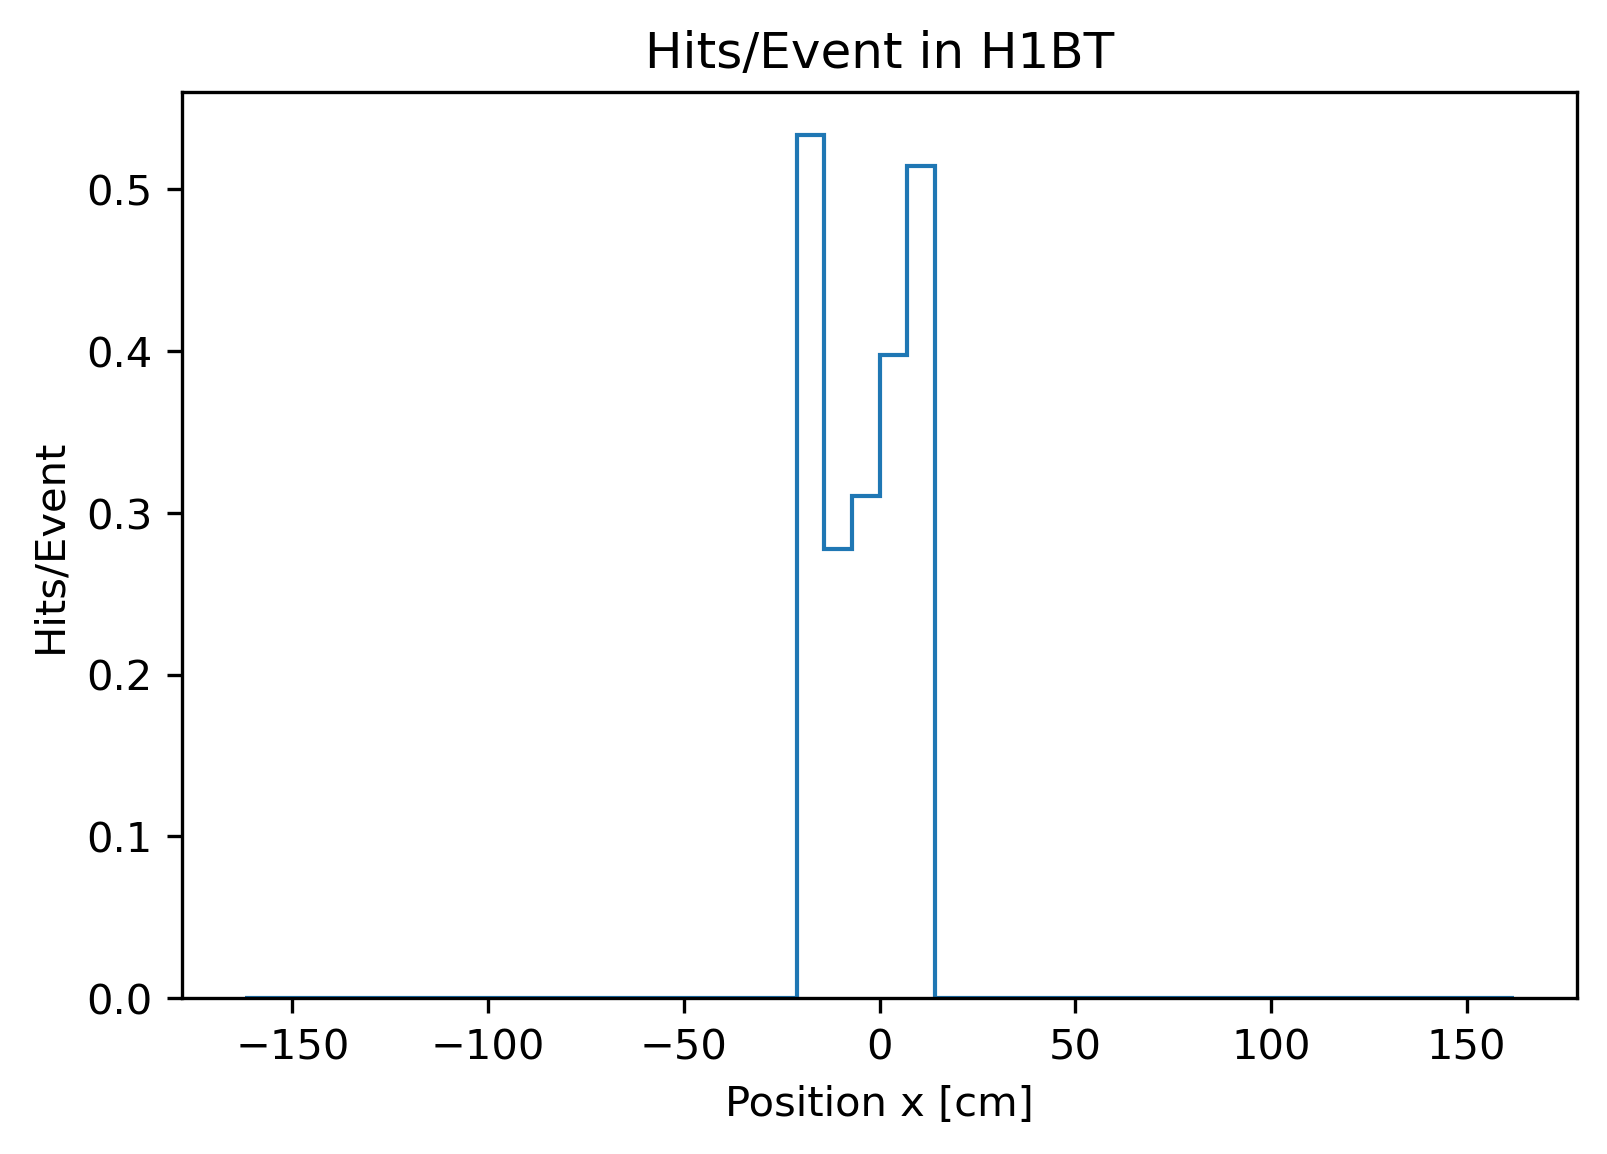

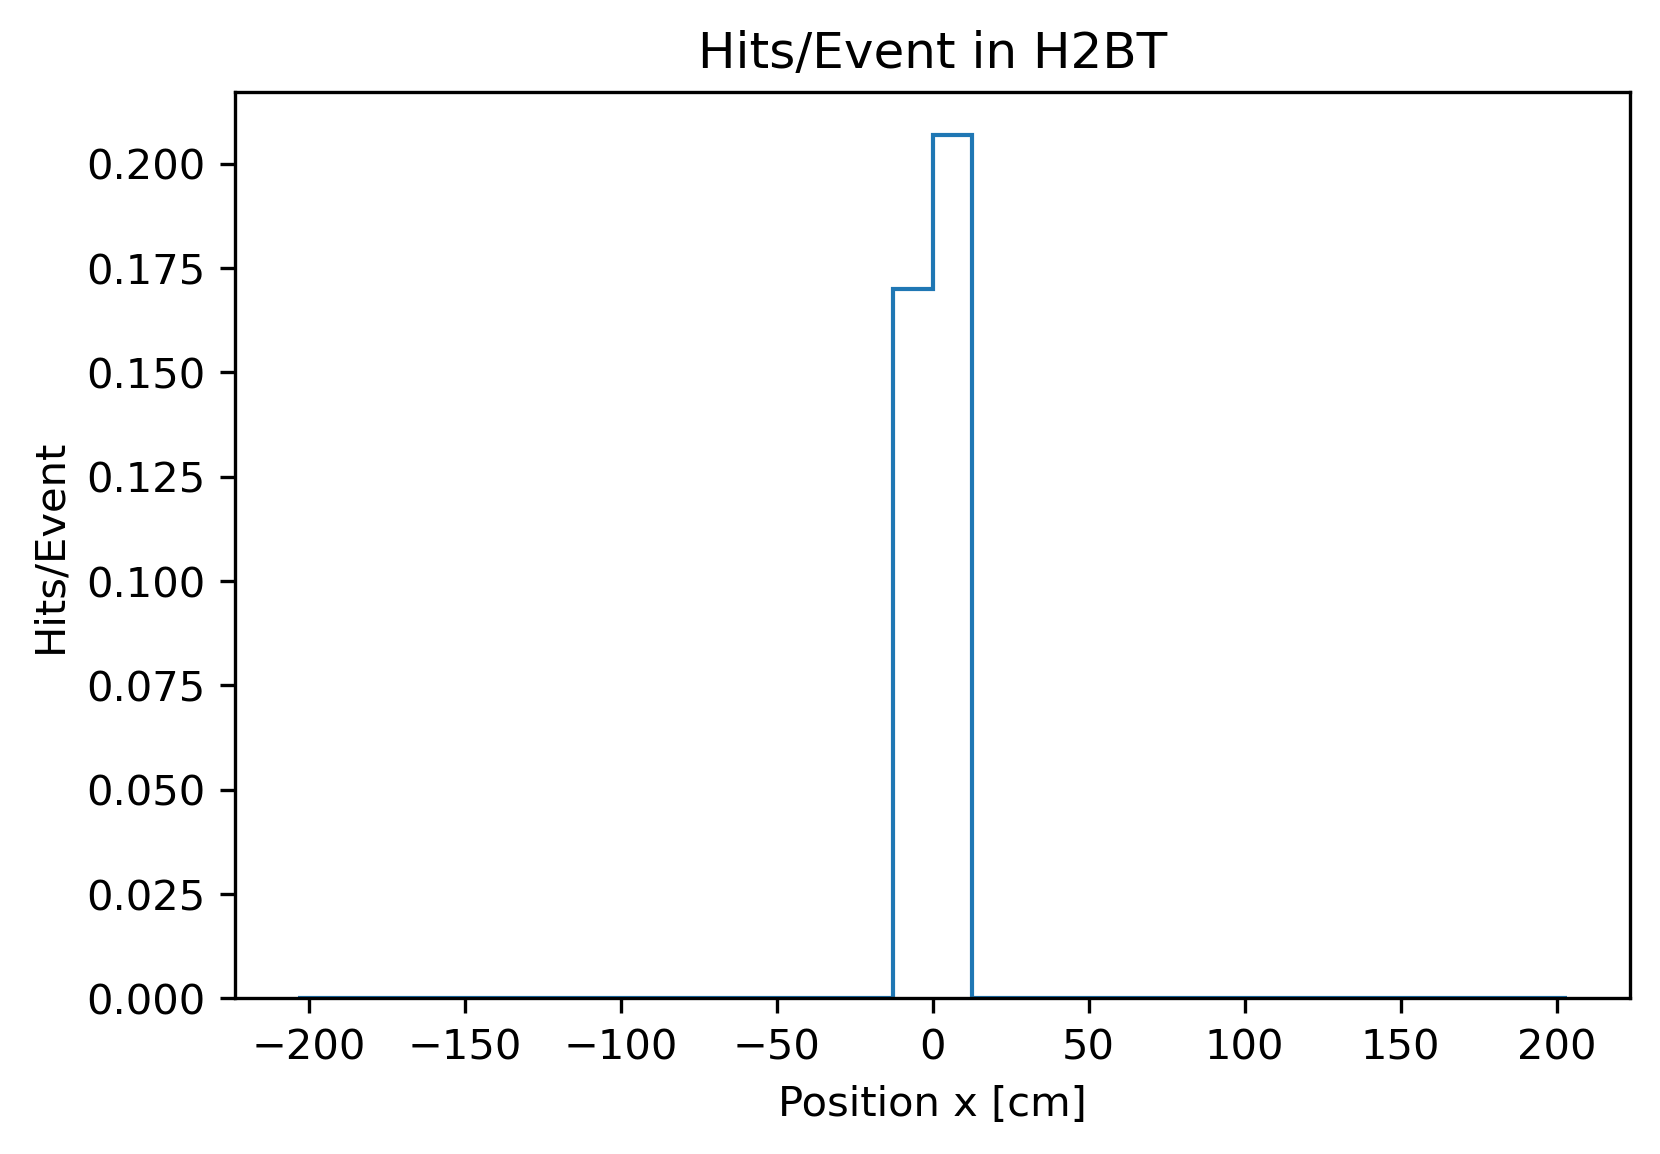

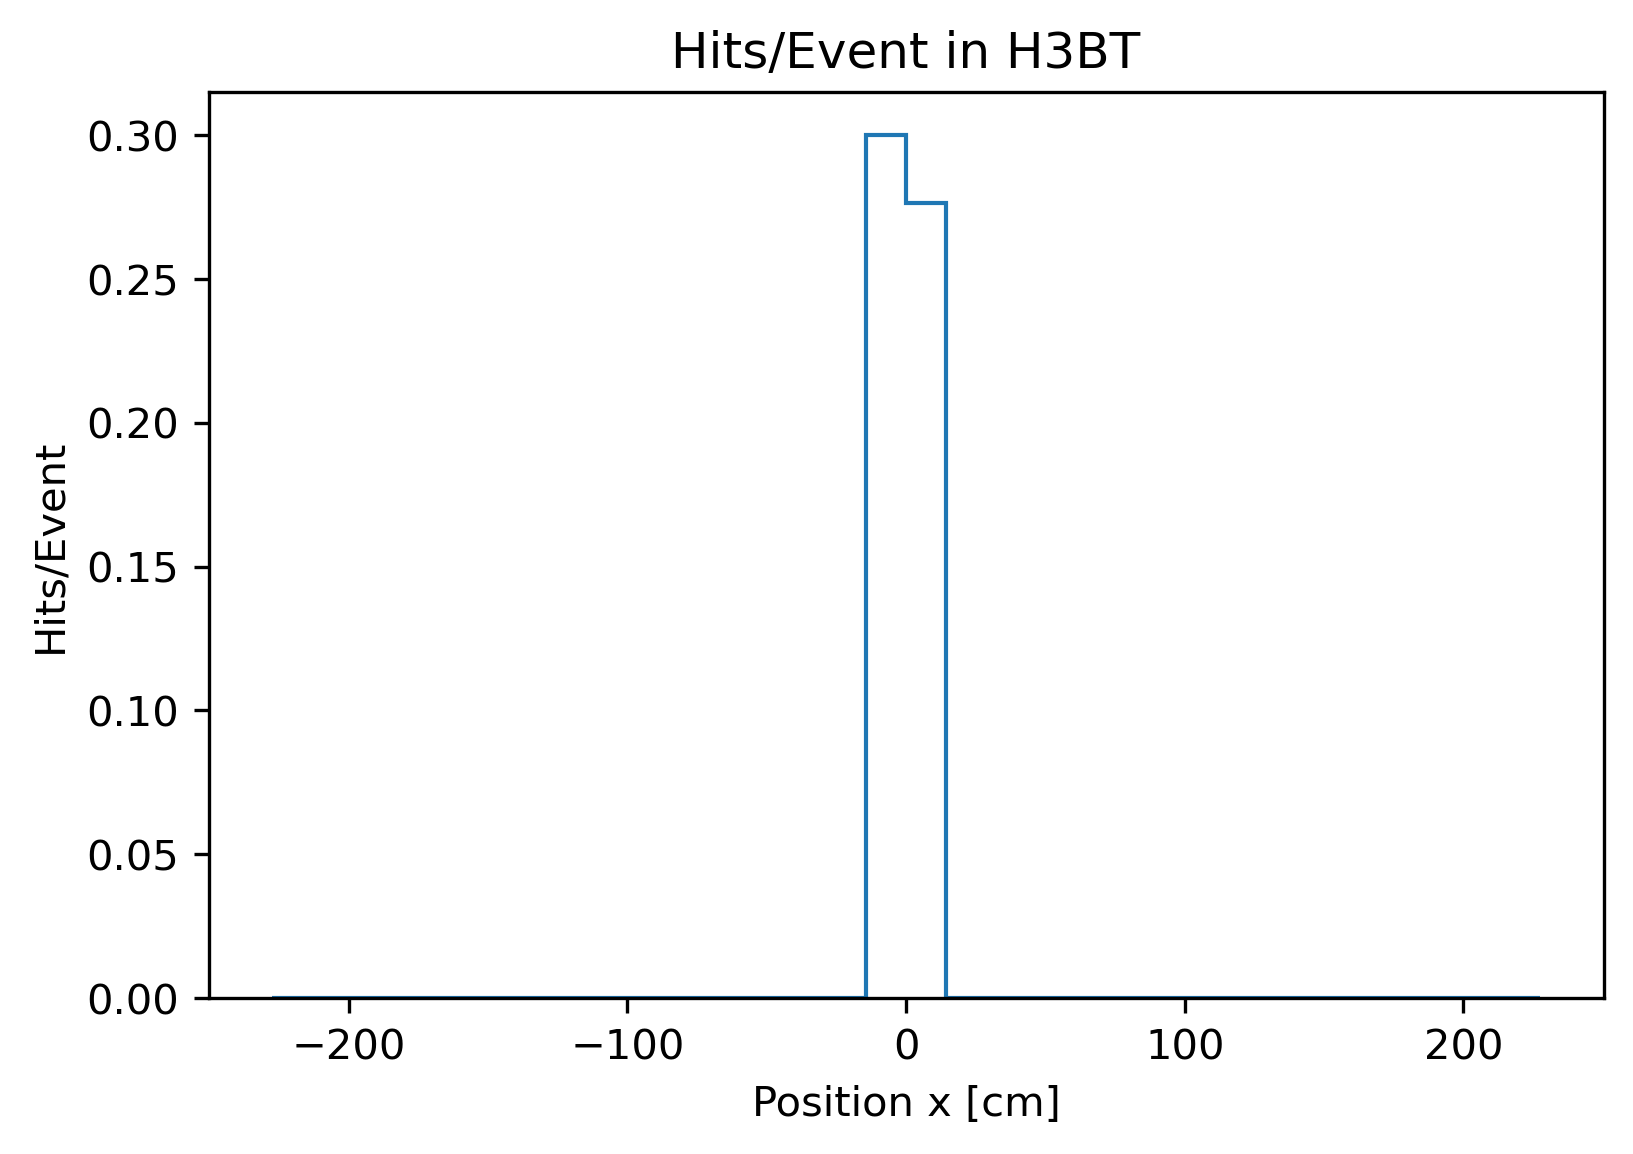

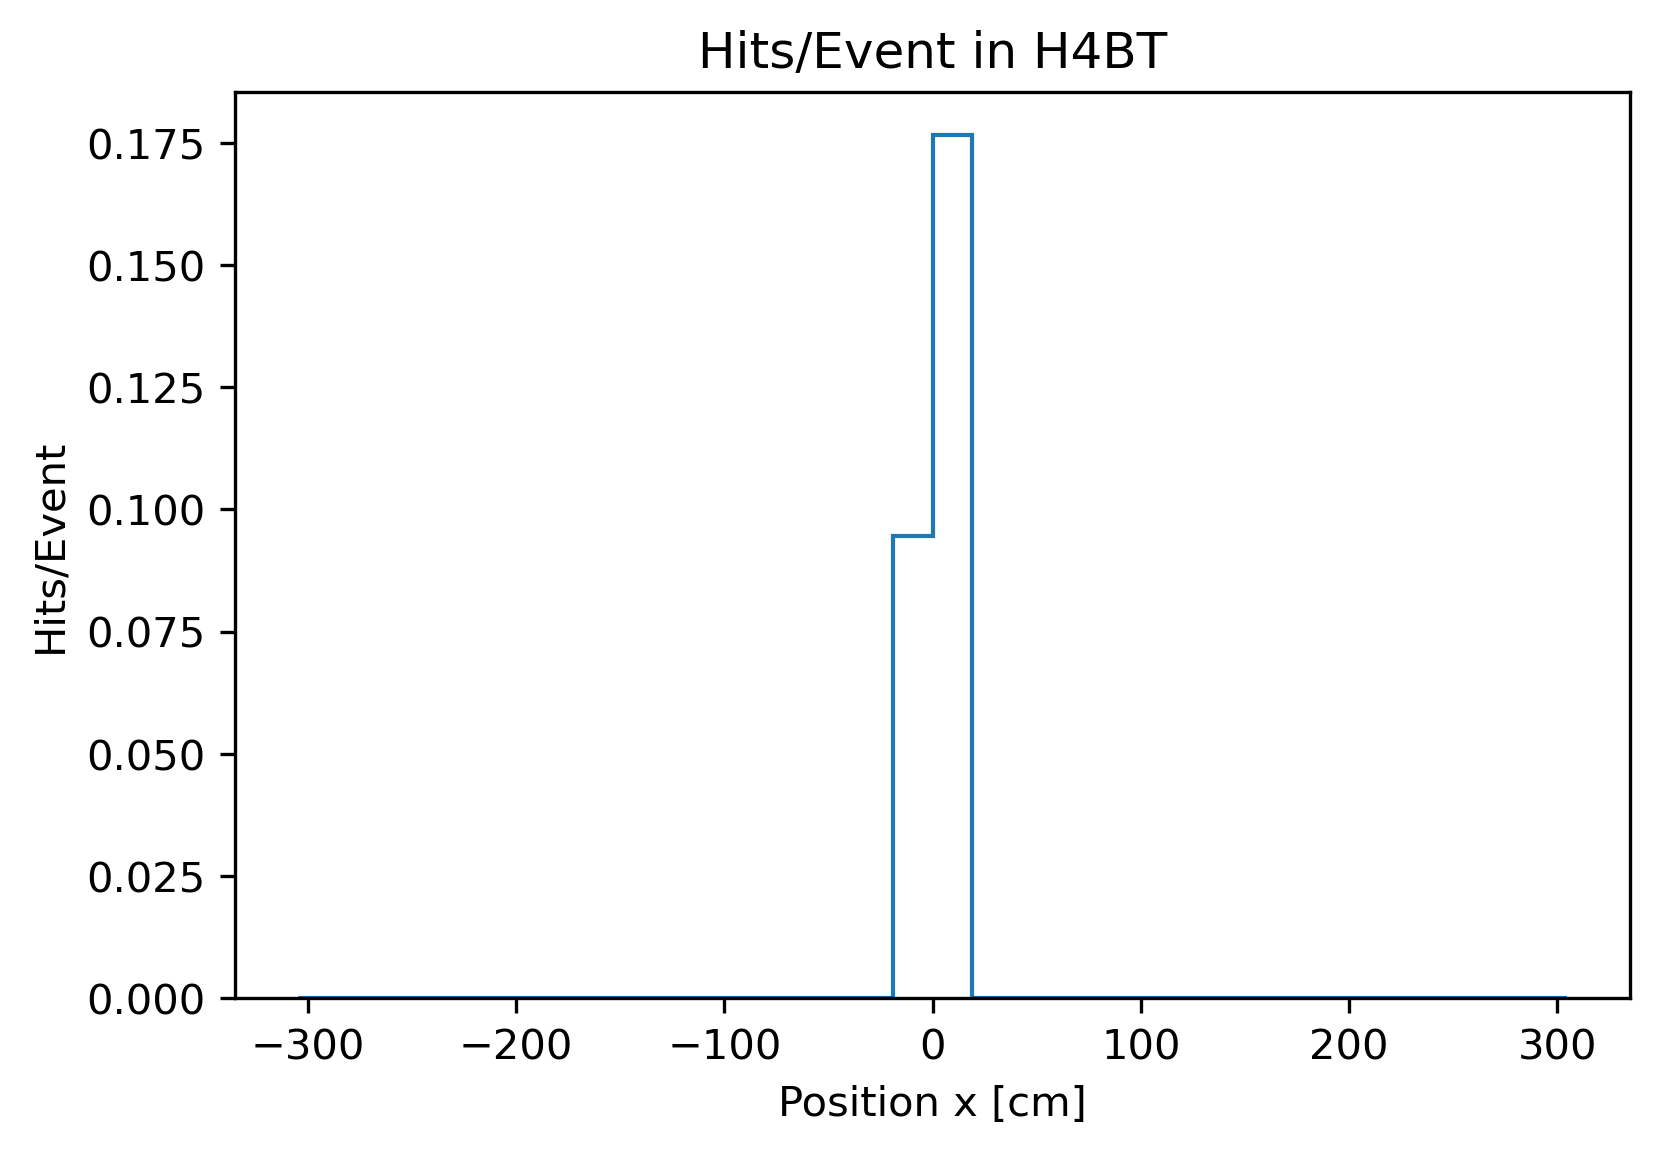

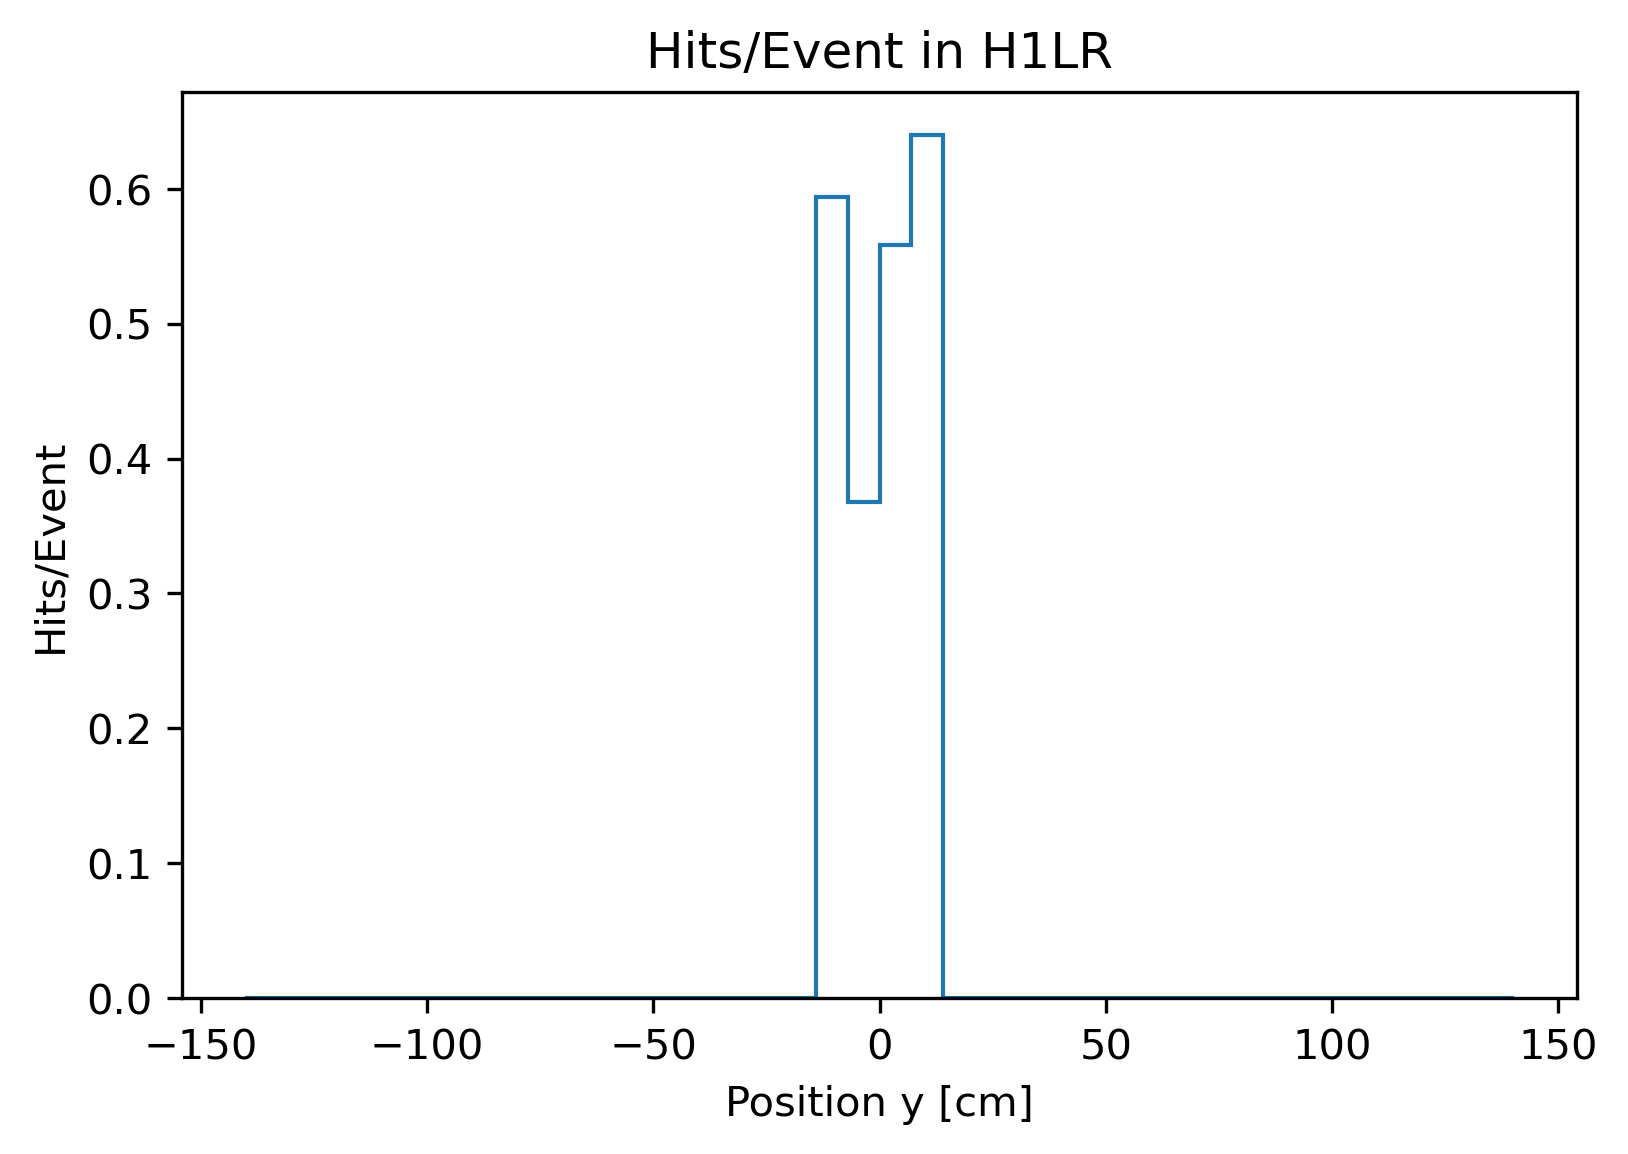

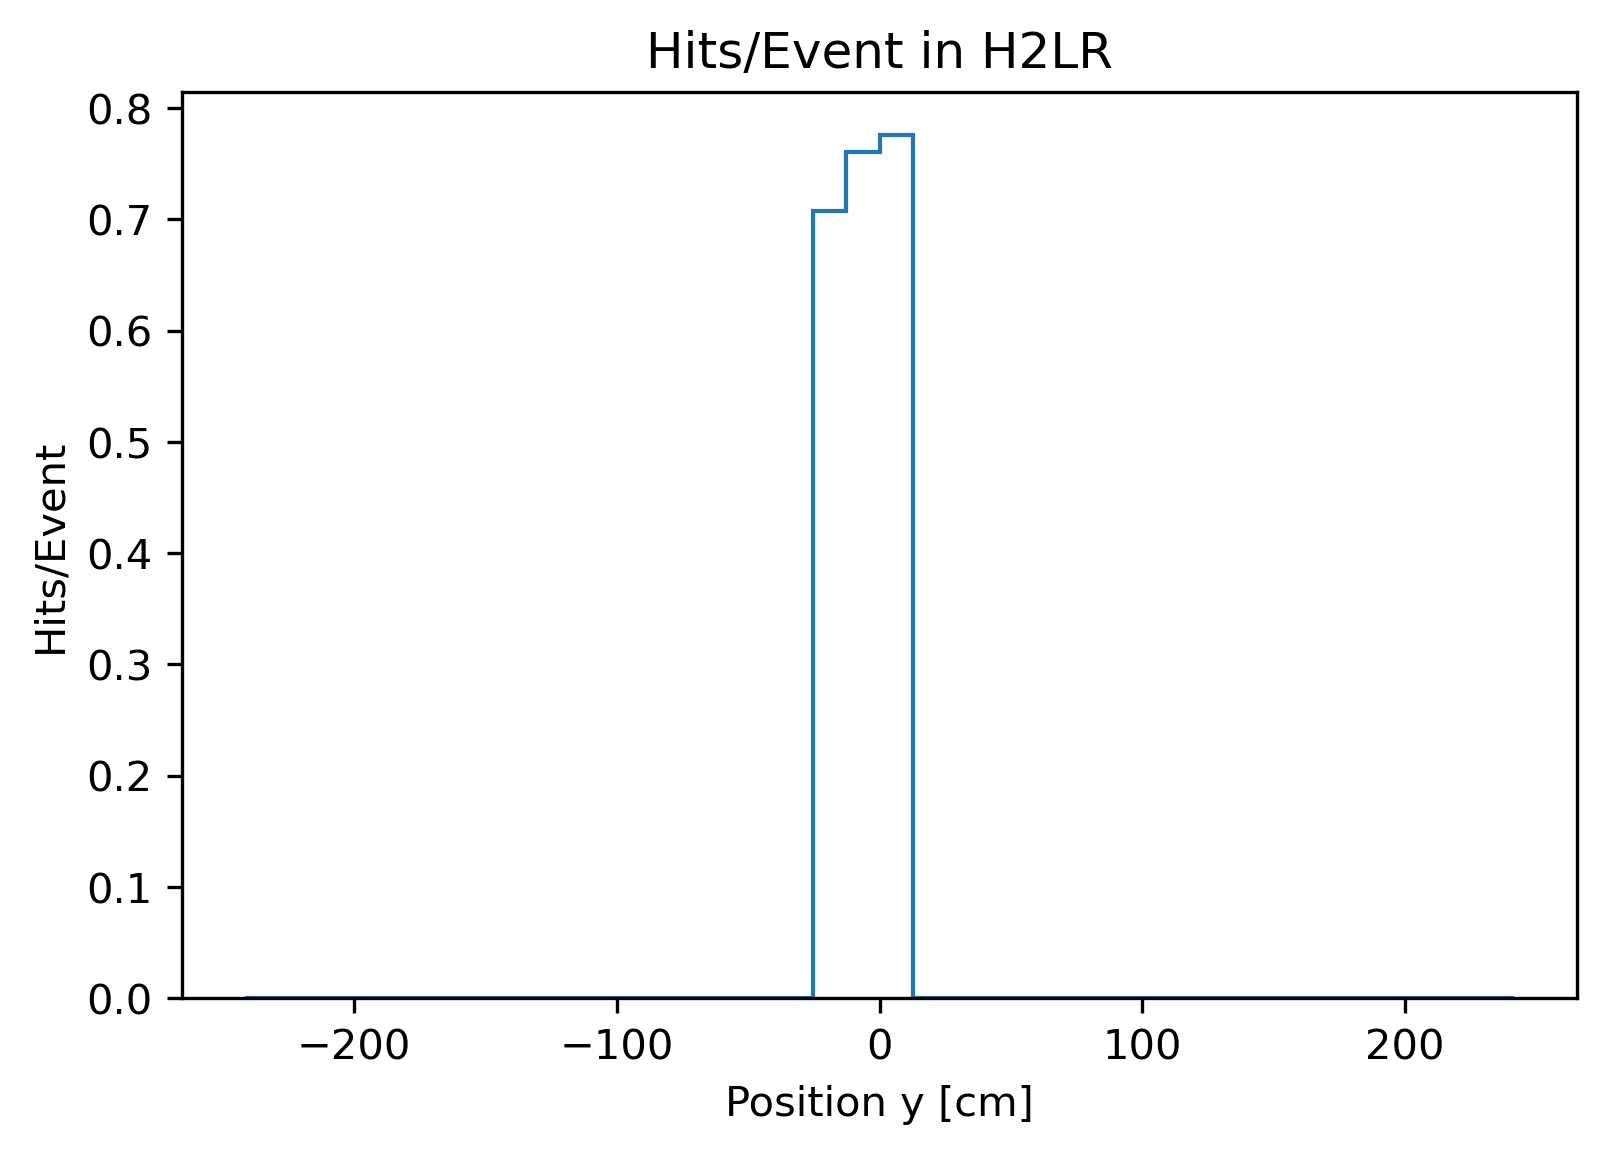

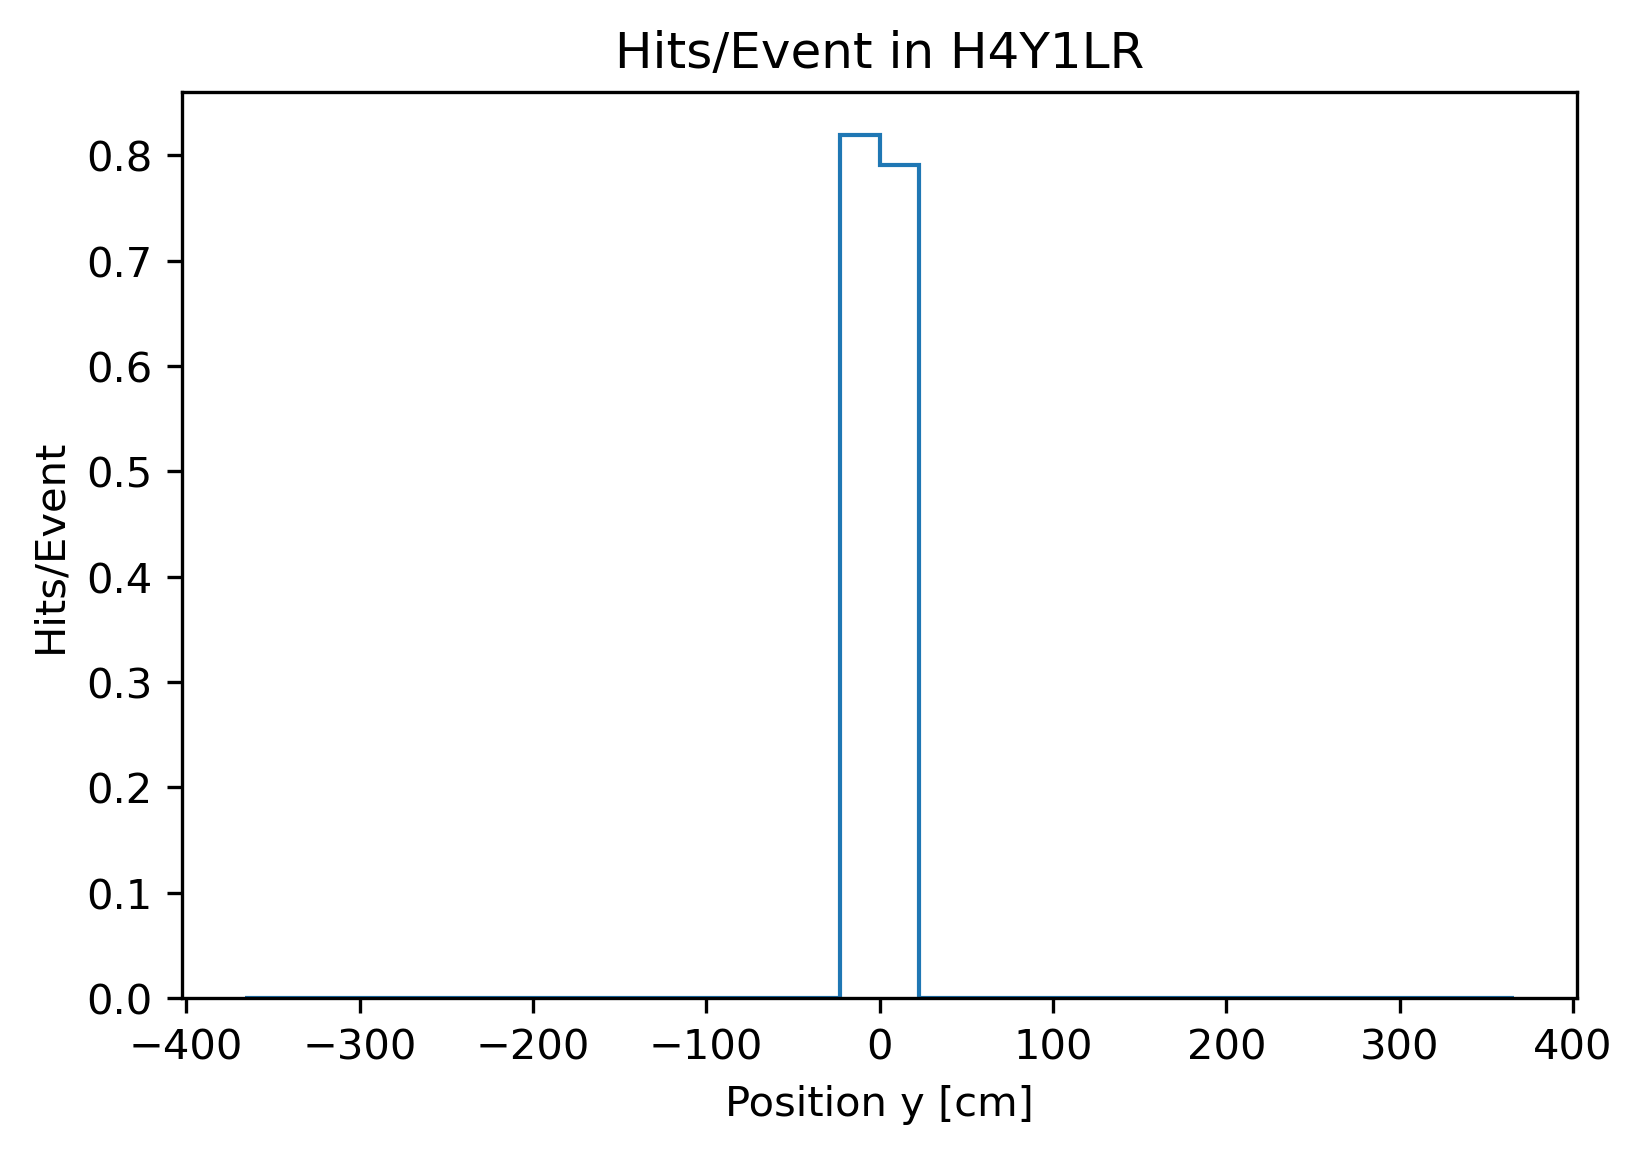

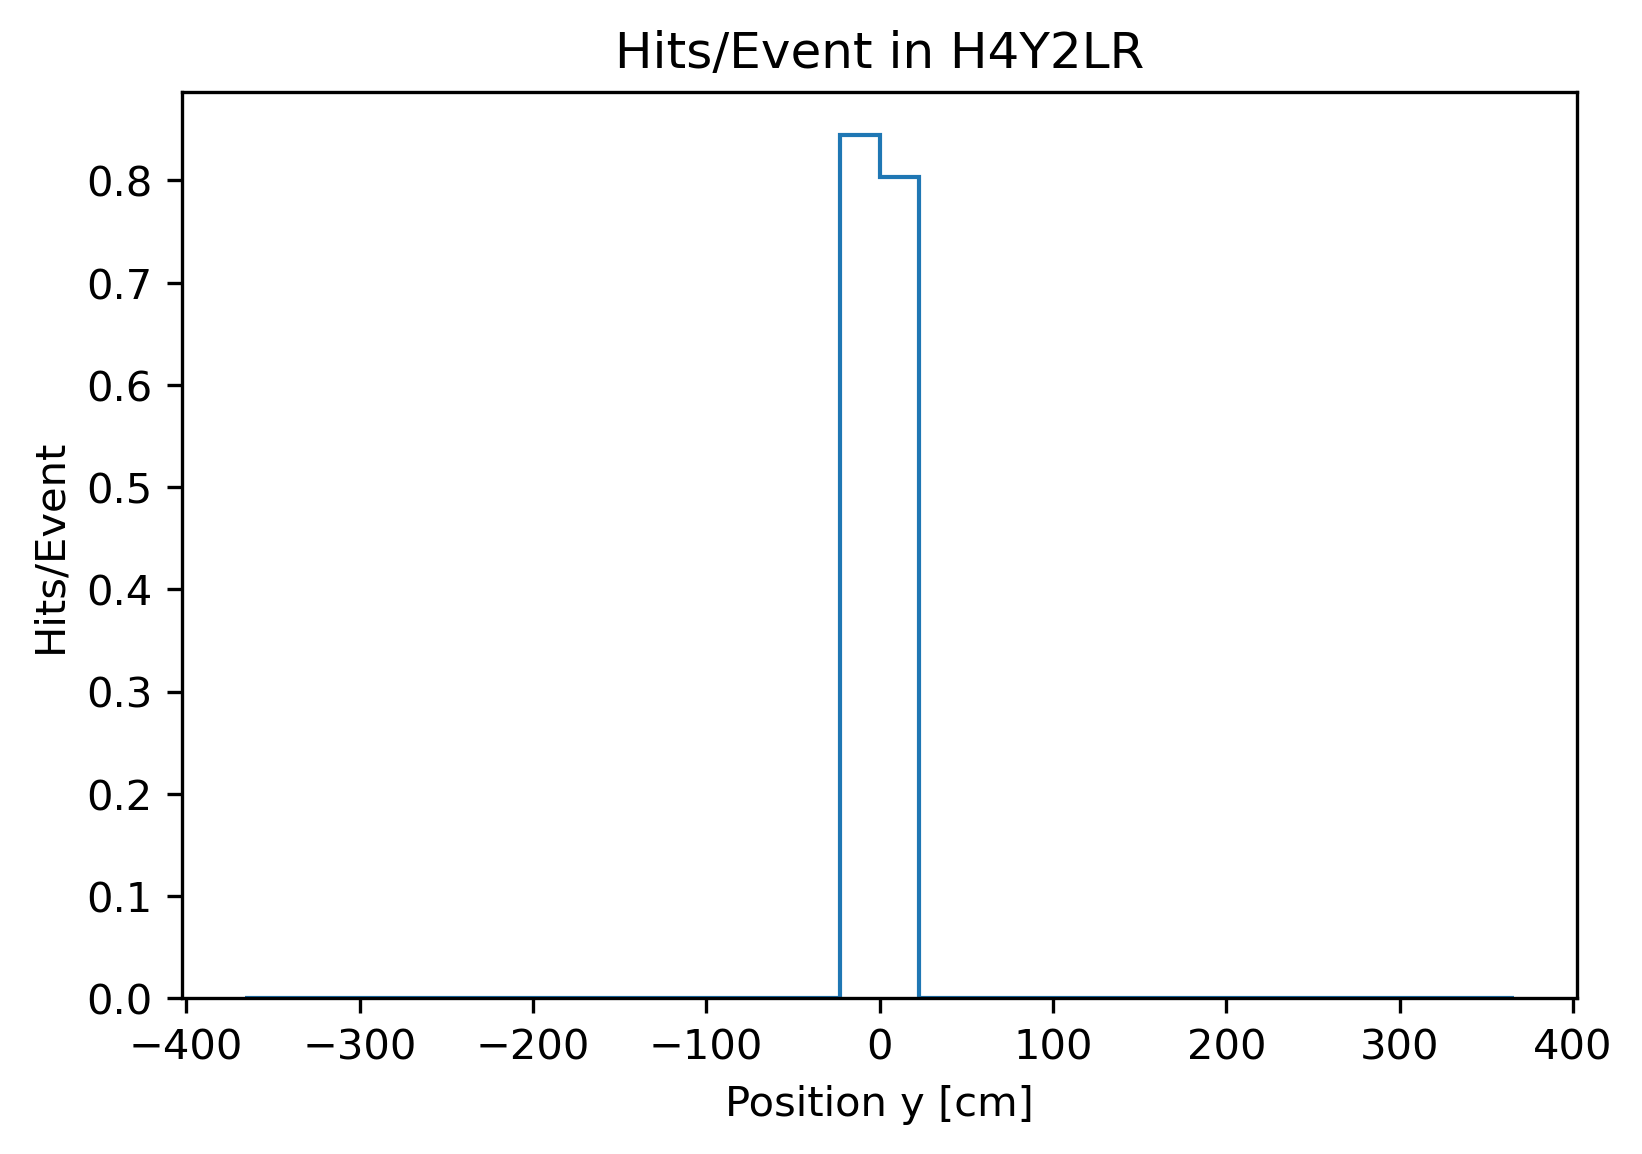

In [82]:
plotHodos(root)

# trying via index, again..


In [48]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def stationMask(arr, detid1, detid2, pos1=-25, pos2=25):
    '''
    Mask the hits based on detid and position to set flags
    the position range goes pos1 <= pos <= pos2 -> [pos1,pos2]
    ST1, ST2 use pos [-14,14] -> two panels on either side x=0
    ST3 uses pos [-15,15] -> one panel on either side x = 0
    '''
    # mask on detectorID
    mask = (arr.detectorID >= detid1) & (arr.detectorID <= detid2)
    # mask on position
    mask = mask & (arr.pos >= pos1)
    mask = mask & (arr.pos <= pos2)
    
    return mask
    
# build detector mask
def detectorMask(arr, level=1, pos1=-25, pos2=25):
    '''
    Mask based on detectorID (plotting all) or
    Mask based on detectorID and pos (for making cut criteria)
    0 = cut
    1 = all
    '''
    detmask = {}
    if (level == 1):   # get all detectors (used for plotting all)
        for key,item in detID_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    elif (level == 0):   # get only BT detectors (used for selection criteria)
        for key,item in sel_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = stationMask(arr,det[0],det[1],pos1,pos2)
    else:
        print("invalid level")
    return detmask

detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

# selection dicts -> run stationMask() on this
sel_dict = {'BT':{'dir':'x',
                  'det':{'H1BT':[31,32],
                         'H2BT':[37,38],
                         'H3BT':[39,40],
                         'H4BT':[45,46]                      
                        }
    
                  }
            }

def flag(dictionary,station=1):
    '''
    looks for the criteria and flags for valid events
    Pass it the selection dictionary, and max station to check
    returns the indices of valid events based on criteria used to create the passed dict
    '''
    nevents = len(dictionary['H1BT'])   # could have used any detector - all have same num of events
    indices = np.array([])
    if (station == 1):
        for i in range(nevents):   # loop thru all events to look for valid events
            if (ak.sum(dictionary['H1BT'][i]) != 0):   # the event has enough hits that meet the criteria
                indices = np.append(indices,i)
            else:
                pass
    else:
        print("not implemented further stations yet")
    return indices

Quick test of flagging (same as in part 4 above)

In [109]:
trigmask = (root.fTriggerBits==65) | (root.fTriggerBits==67)
allhits = root.fAllHits
st1_mask = detectorMask(allhits,0)
det_mask = detectorMask(allhits,1)

cut = flag(st1_mask)
nocut = flag(det_mask)

print("cut: {}\n".format(len(cut)))
print("no cut: {}\n".format(len(nocut)))

cut: 82186

no cut: 159373



**Plotting**

In [51]:
def plotHodos(root, pos1=-25, pos2=25):
    '''
    takes a ROOT file and plots the hit/event rate for all hodoscopes
    [pos1, pos2] -> x-range for determining station1 criteria
    '''
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    
    # this is what is normally plotted
    detmask = detectorMask(allhits,1)   # pos1, pos2 not needed here
    
    # mask by station 1 criteria
    st1mask = detectorMask(allhits,0,pos1,pos2)

    # now get the indices
    indices = flag(st1mask)
    
    
    # binning and range information.
    bins_range = [(46, (-162.008,162.008)),    # H1BT
                  (32, (-203.238,203.238)),    # H2BT
                  (32, (-227.518,227.518)),    # H3BT
                  (32, (-304.518,304.518)),    # H4BT
                  (40, (-140.117,140.117)),    # H1LR
                  (38, (-241.285,241.285)),    # H2LR
                  (32, (-365.797,365.797)),    # H4Y1LR
                  (32, (-365.797,365.797)),    # H4Y2LR
                  ]
    
    # get the proper binning/range for each hist
    choose_bins = 0

    # number of valid events to loop thru after selecting for station 1 criteria
    nevents = len(indices)
    print("nevents after station 1 criteria: {}\n".format(nevents))
    
    # weighing -> we weigh by the total number of hits given by triggerBits
    weight = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))
    print("num of valid events by triggerBits {}\n".format(weight))
    
    # plotting
    for dets, item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            # hits masked by fTriggerBits 
            maskedhits_det = maskedhits[detmask[det]]
            
            # debug
            #print(len(maskedhits_det.pos))
            #print(maskedhits_det.pos[100])
            
            #print(ak.sum(ak.flatten(maskedhits_det.pos)))
            
            '''
            for i in range(len(maskedhits_det.pos)):
                if maskedhits_det.pos[i] != None:
                    print(maskedhits_det.pos[i])
            '''
            
            # hold the positions of the valid events
            valid = np.array([])
            # keep track of the number of valid events (for weighing? - prob just use weight above)
            validEvents = 0
            for i in range(nevents):
                # fill the array with the valid hits as defined by criteria
                #print(maskedhits_det.pos[i])
                if maskedhits_det.pos[i] != None:
                    valid = np.append(valid, ak.to_numpy(maskedhits_det.pos[i]))
                    validEvents += 1
            
            # weighing (either use validEvents or weight to divide by, need to think a bit first)
            ws = np.ones_like(valid)/weight
            if (choose_bins==3) or (choose_bins==6) or (choose_bins==7):
                ws /= 2
            '''
            ws = np.ones_like(valid)/validEvents
            if (choose_bins==3) or (choose_bins==6) or (choose_bins==7):
                ws /= 2
            '''
            
            title = "Hits/Event in {}".format(det)
            savename = det+"_"+"station1_cut_2017"
            fig = plt.figure(dpi=300)
            plt.hist(valid, bins=bins_range[choose_bins][0],
                     range=bins_range[choose_bins][1],
                     histtype='step',weights=ws)
            plt.ylabel("Hits/Event")
            plt.xlabel("Position {} [cm]".format(direction))
            plt.title(title)
            #plt.savefig(savename)
            plt.show()
            
                
            choose_bins += 1
            
            #return valid

nevents after station 1 criteria: 47155

num of valid events by triggerBits 677



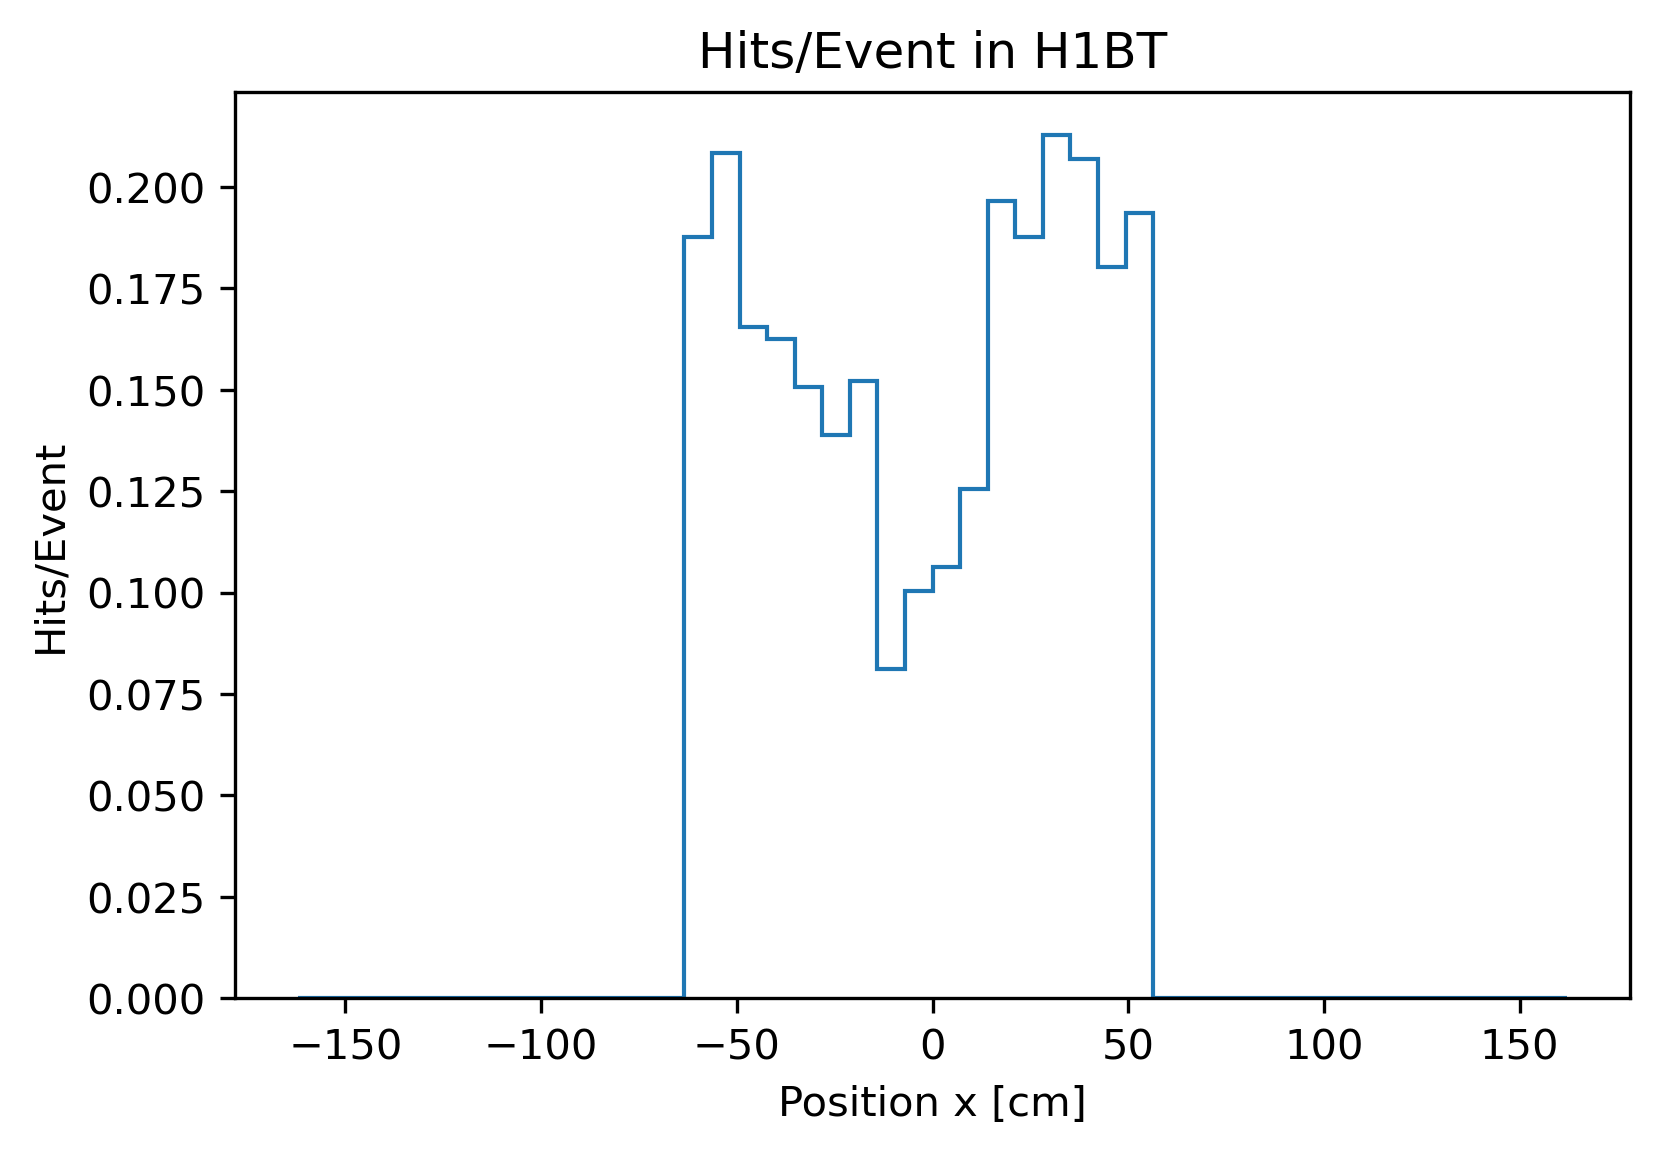

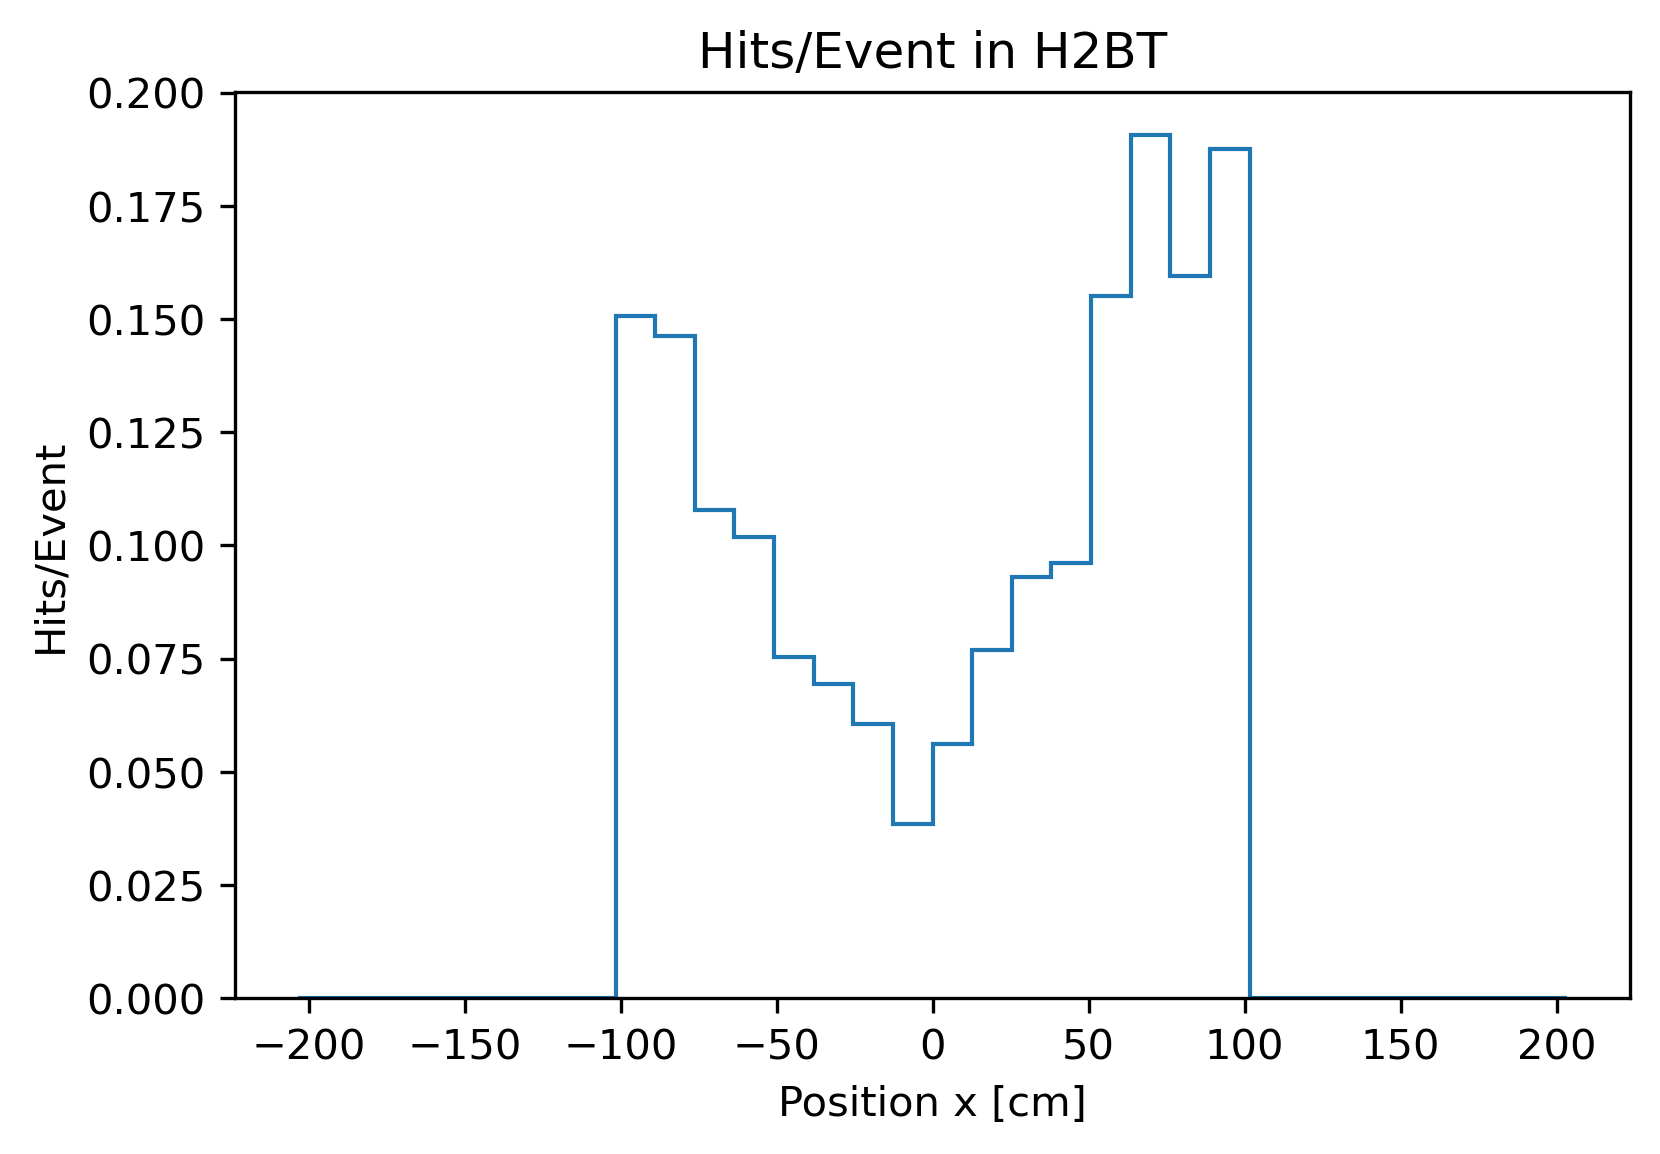

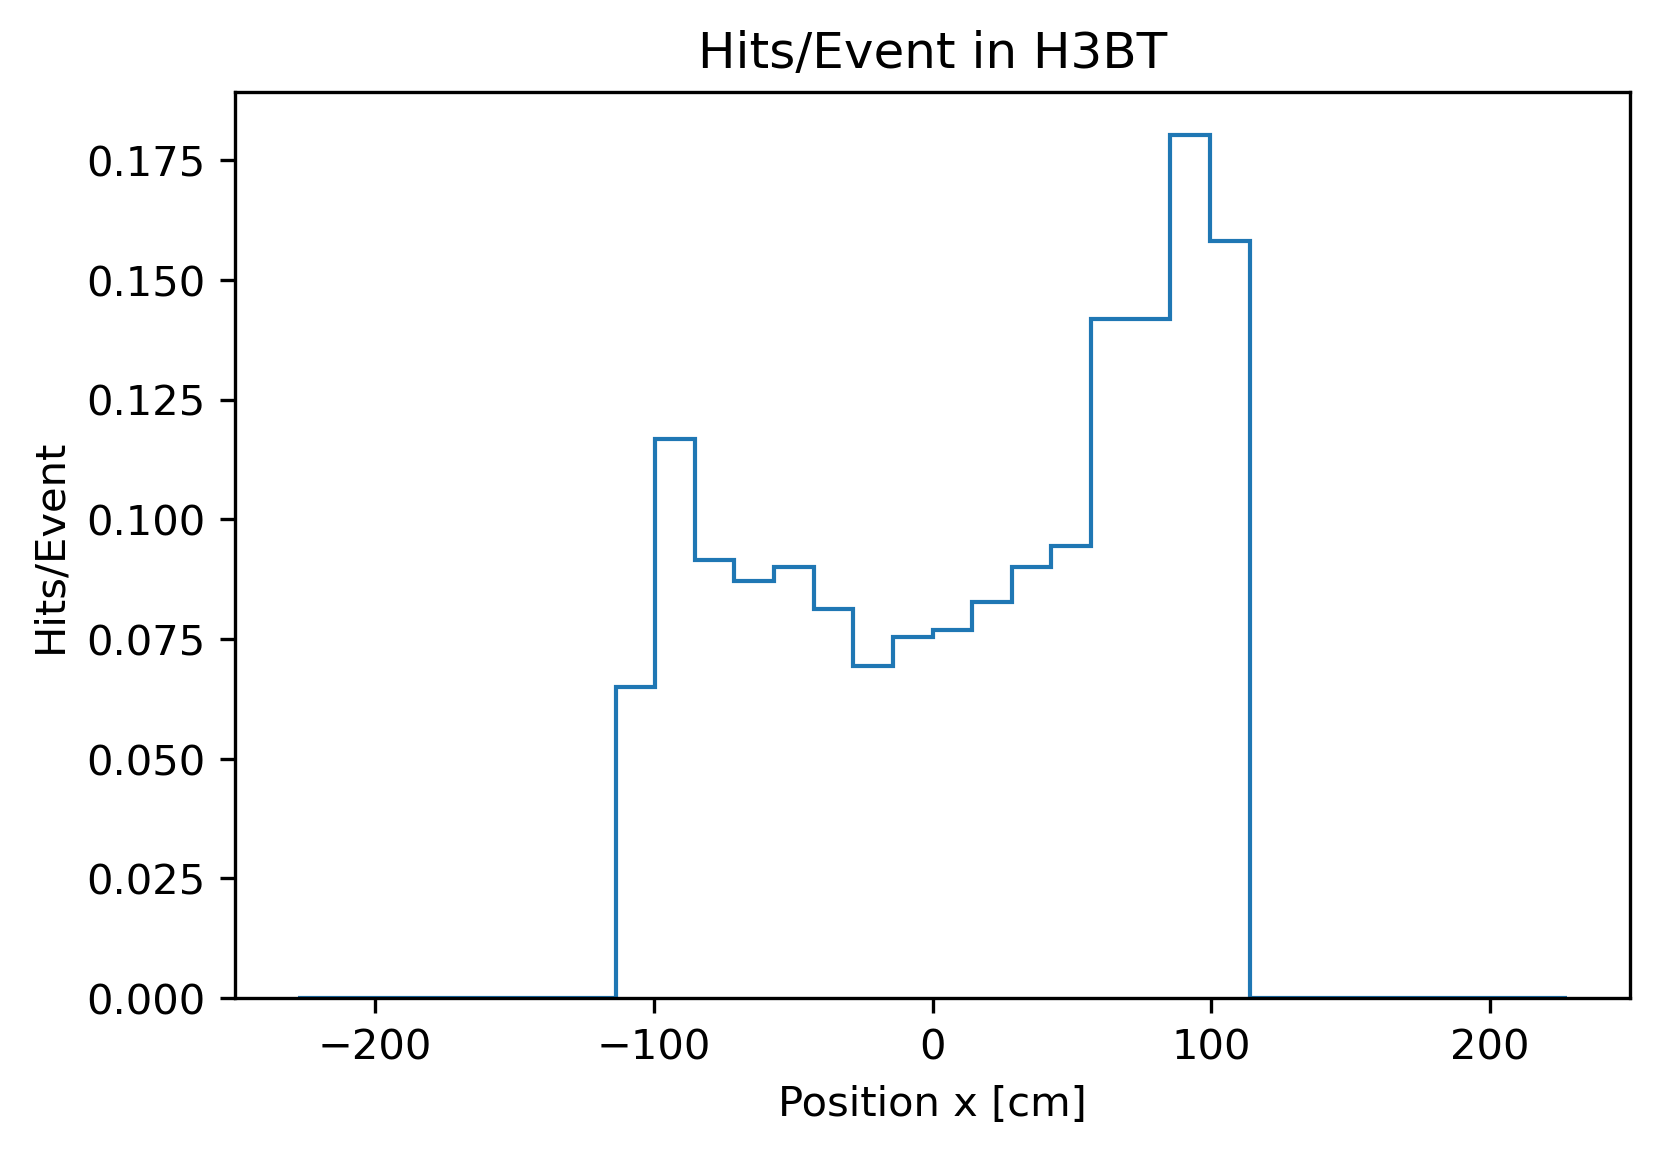

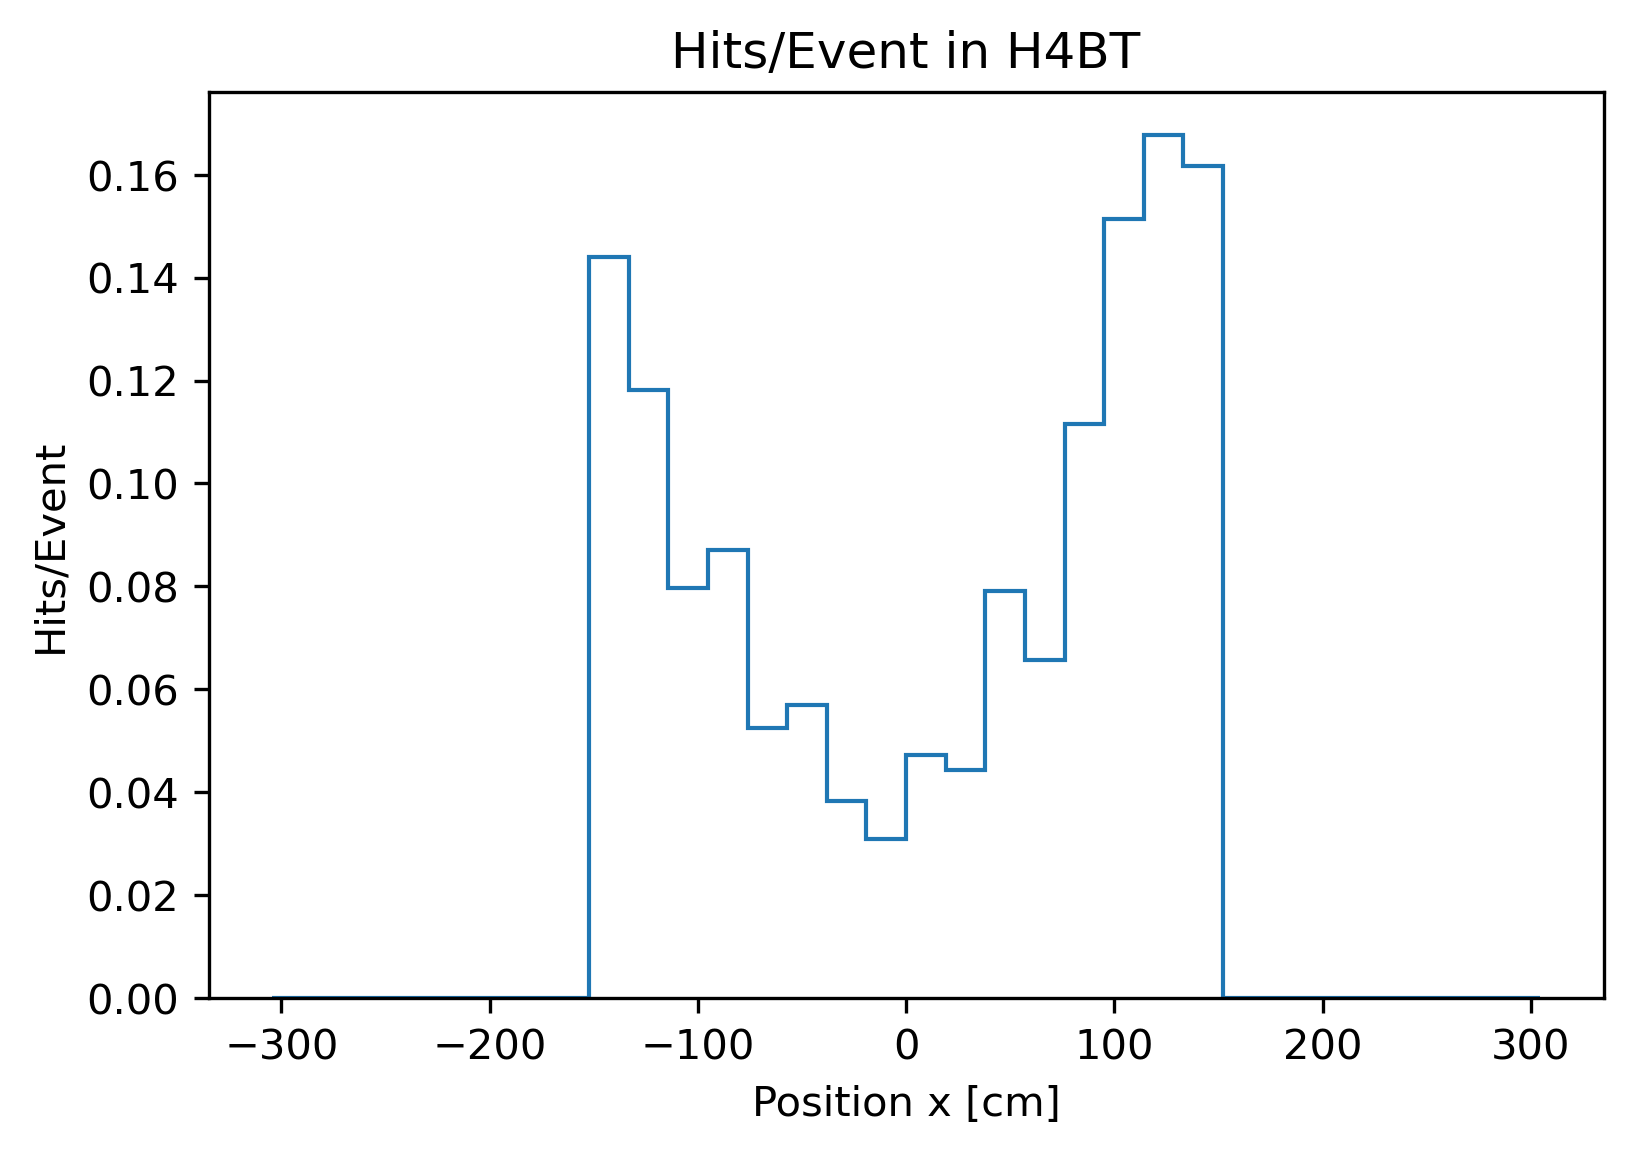

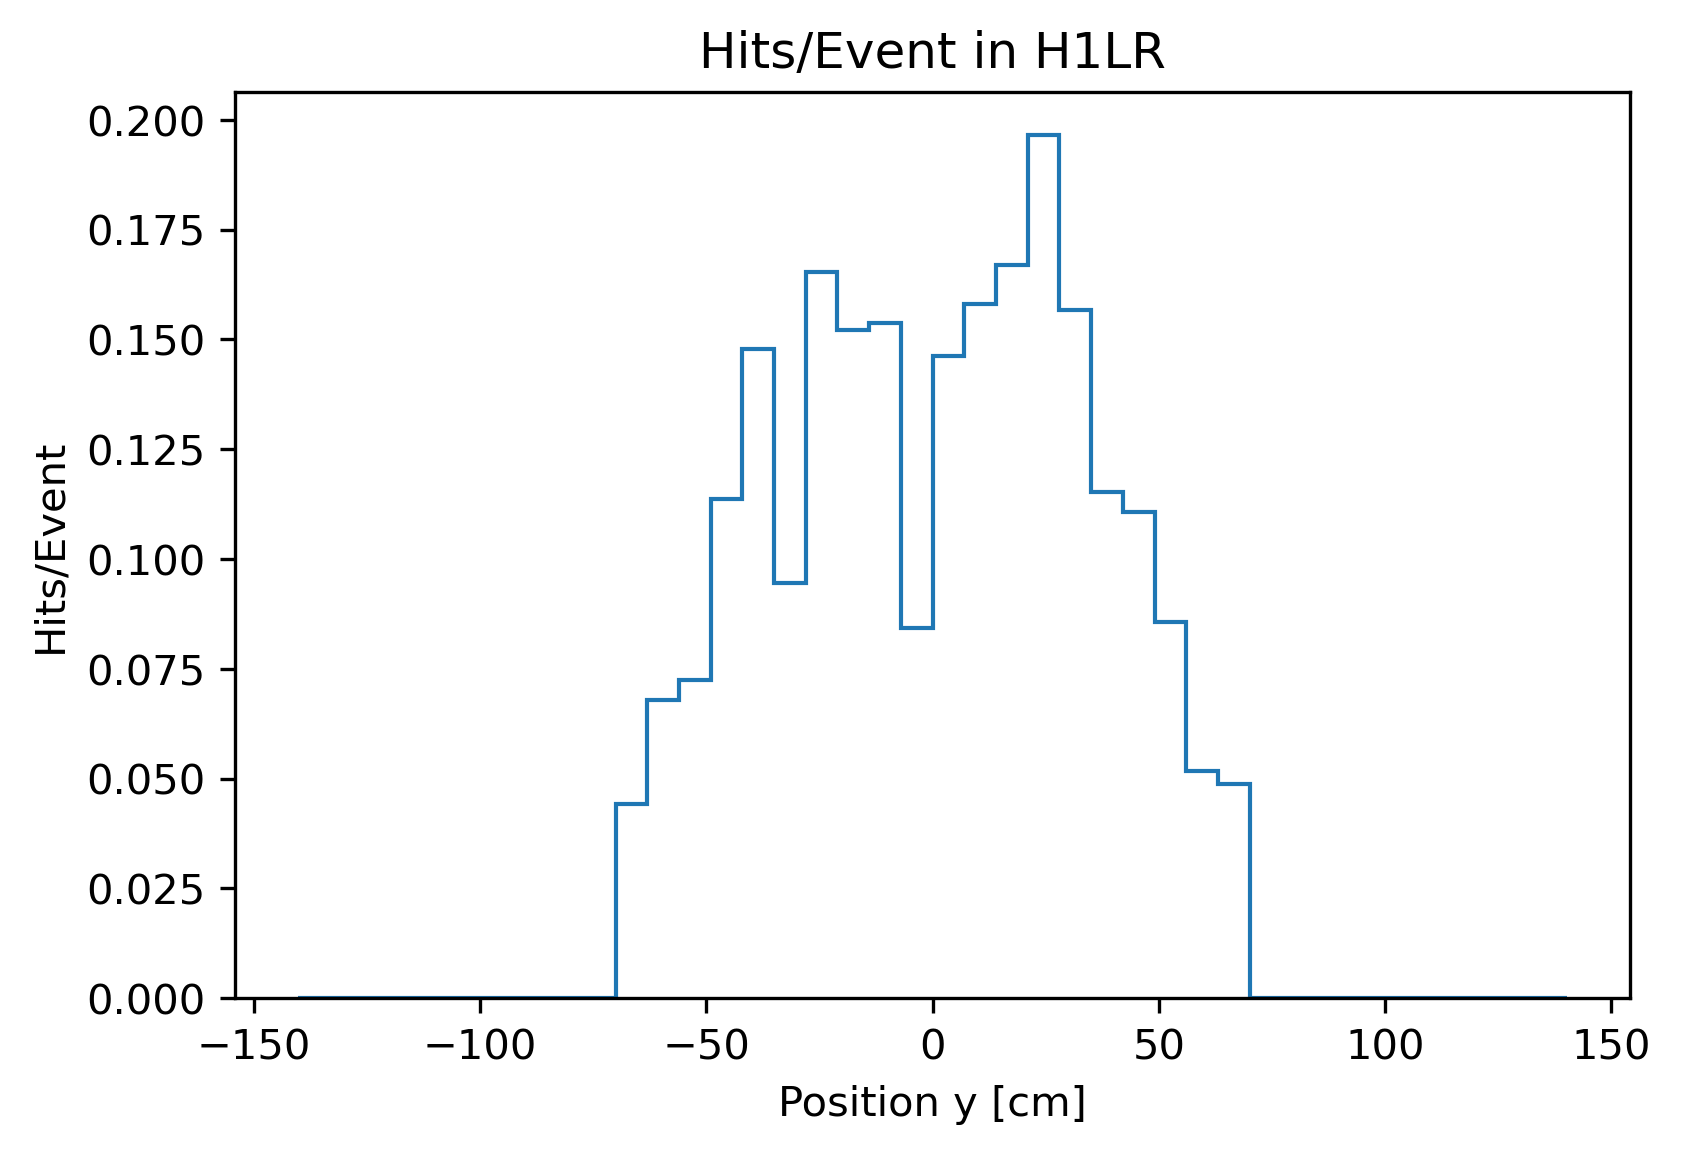

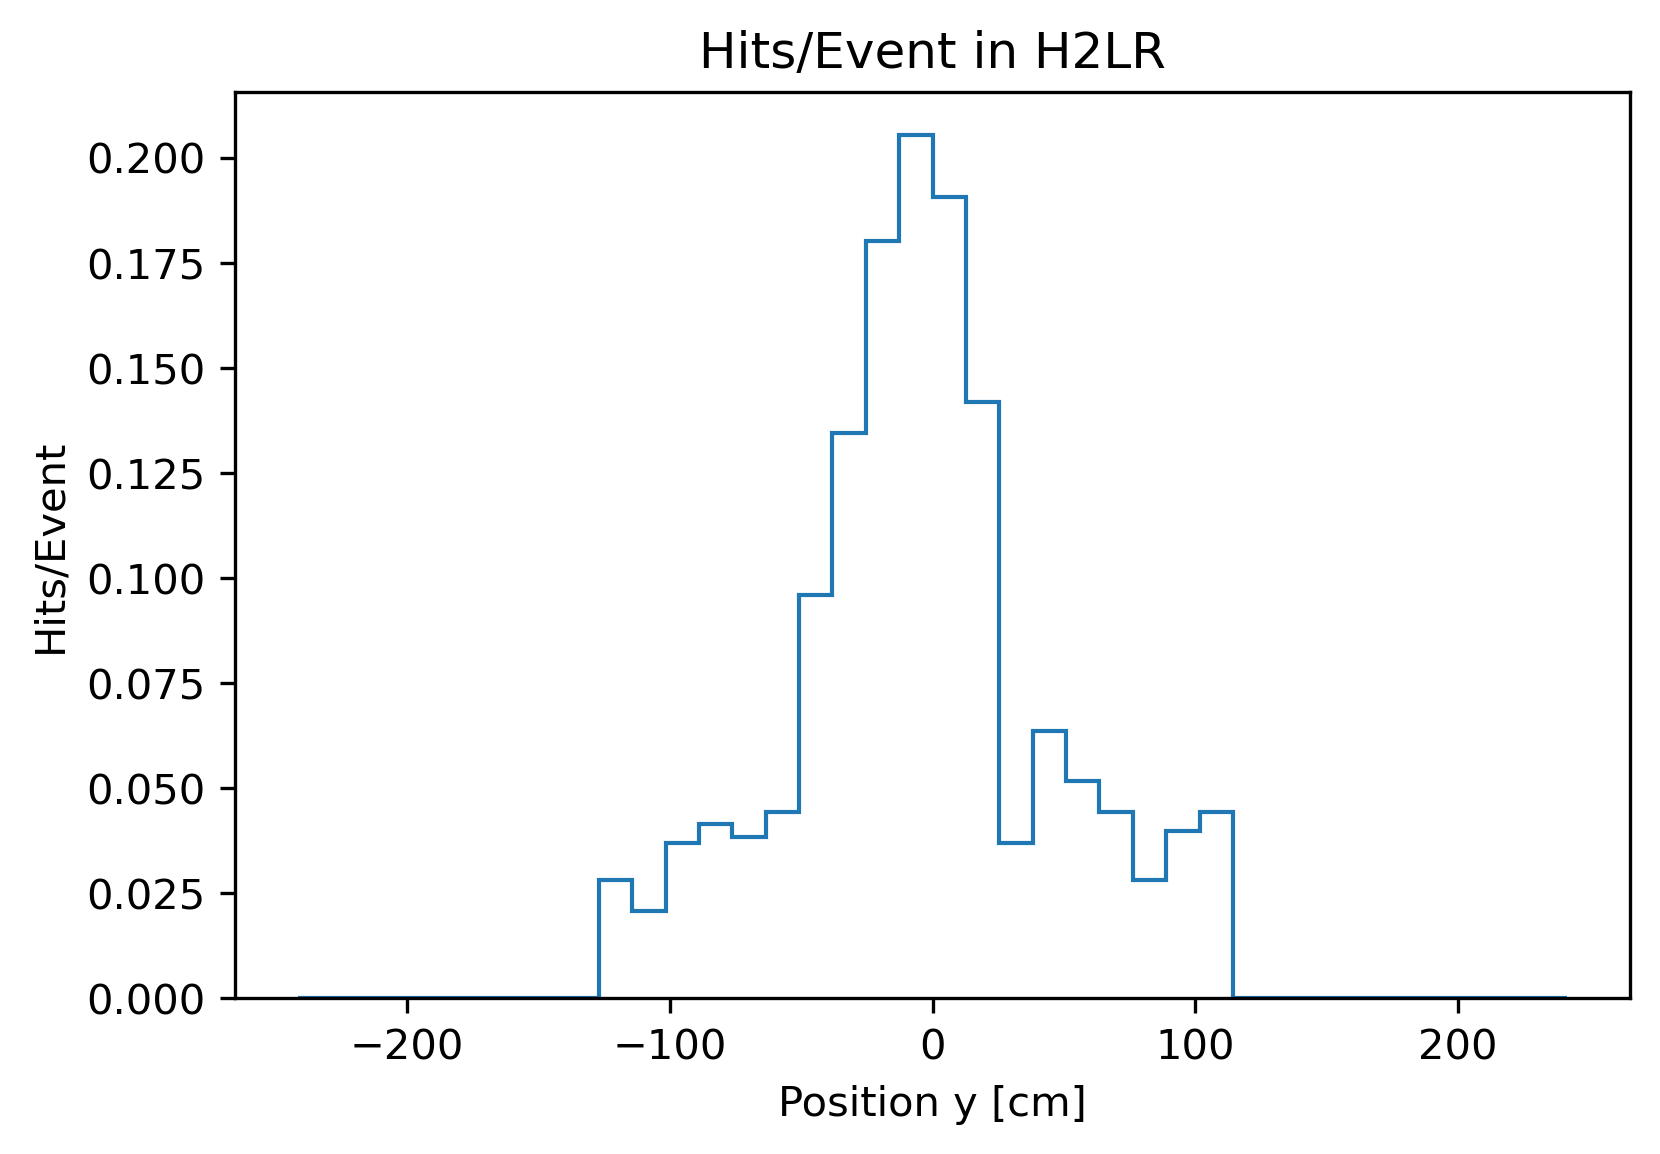

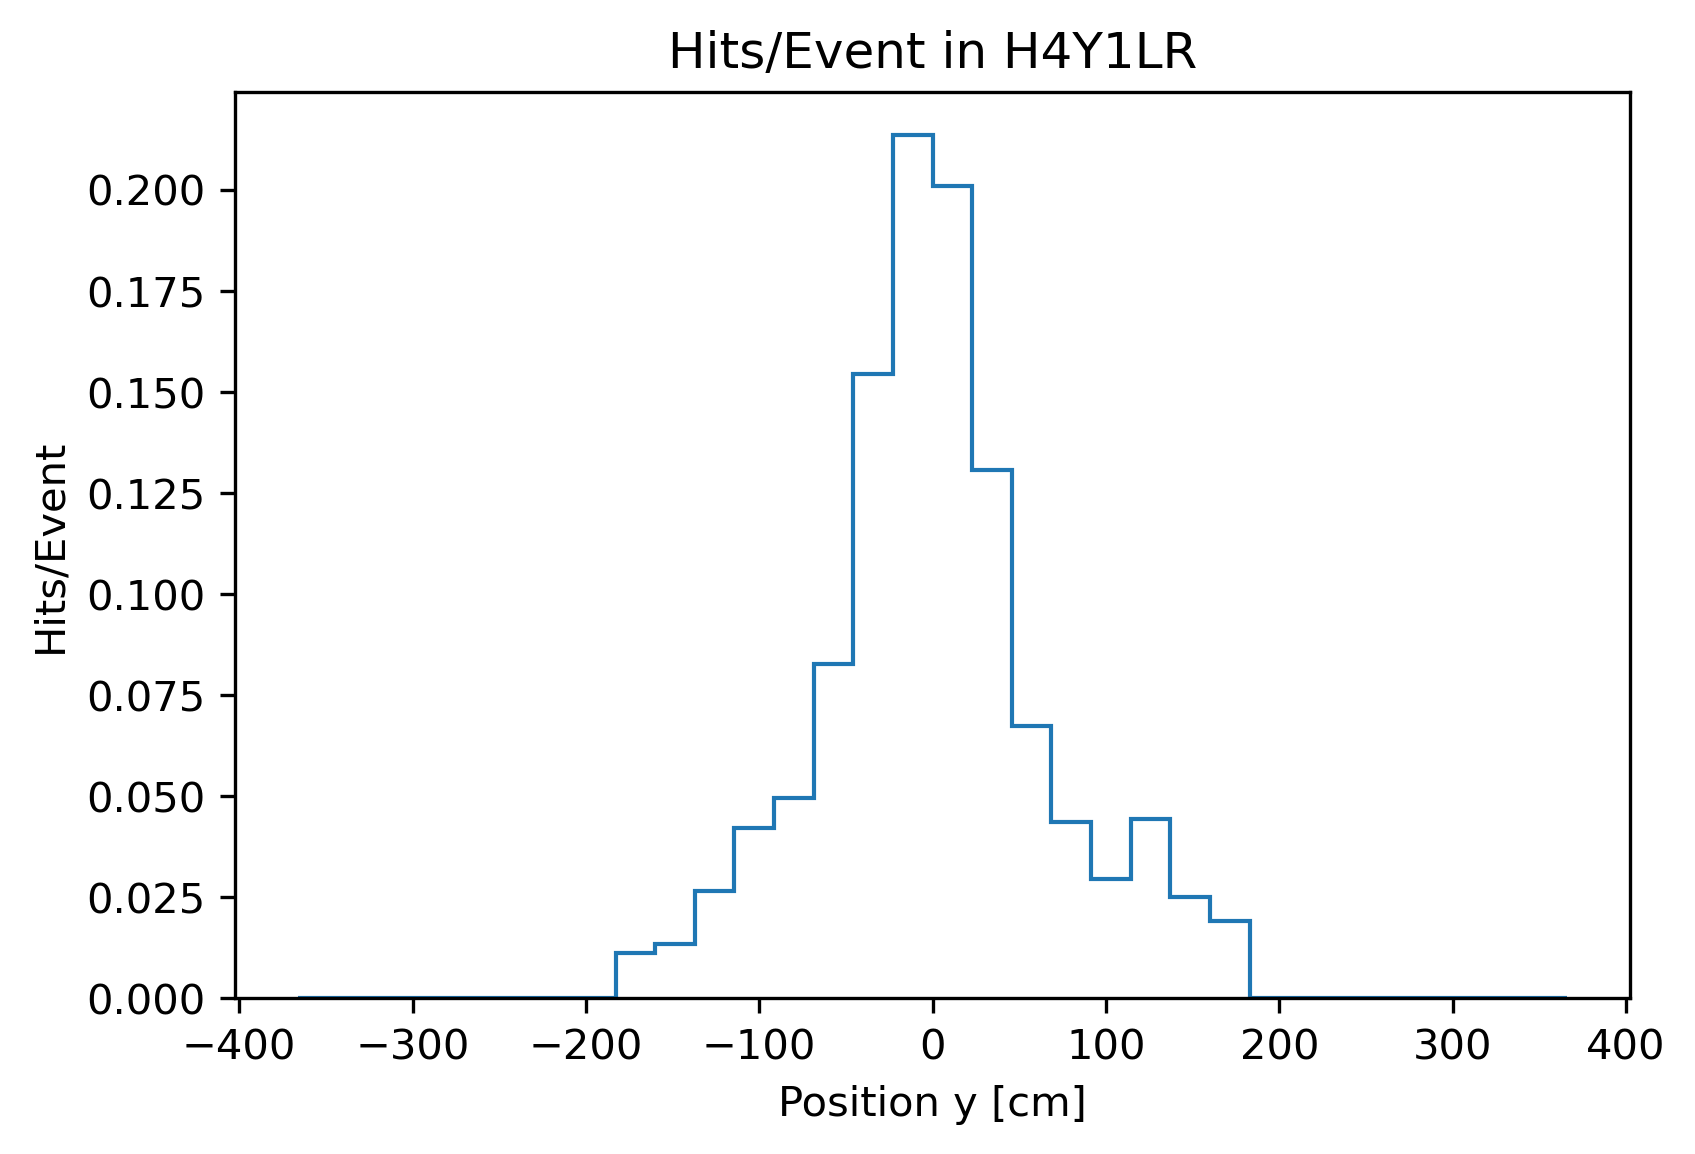

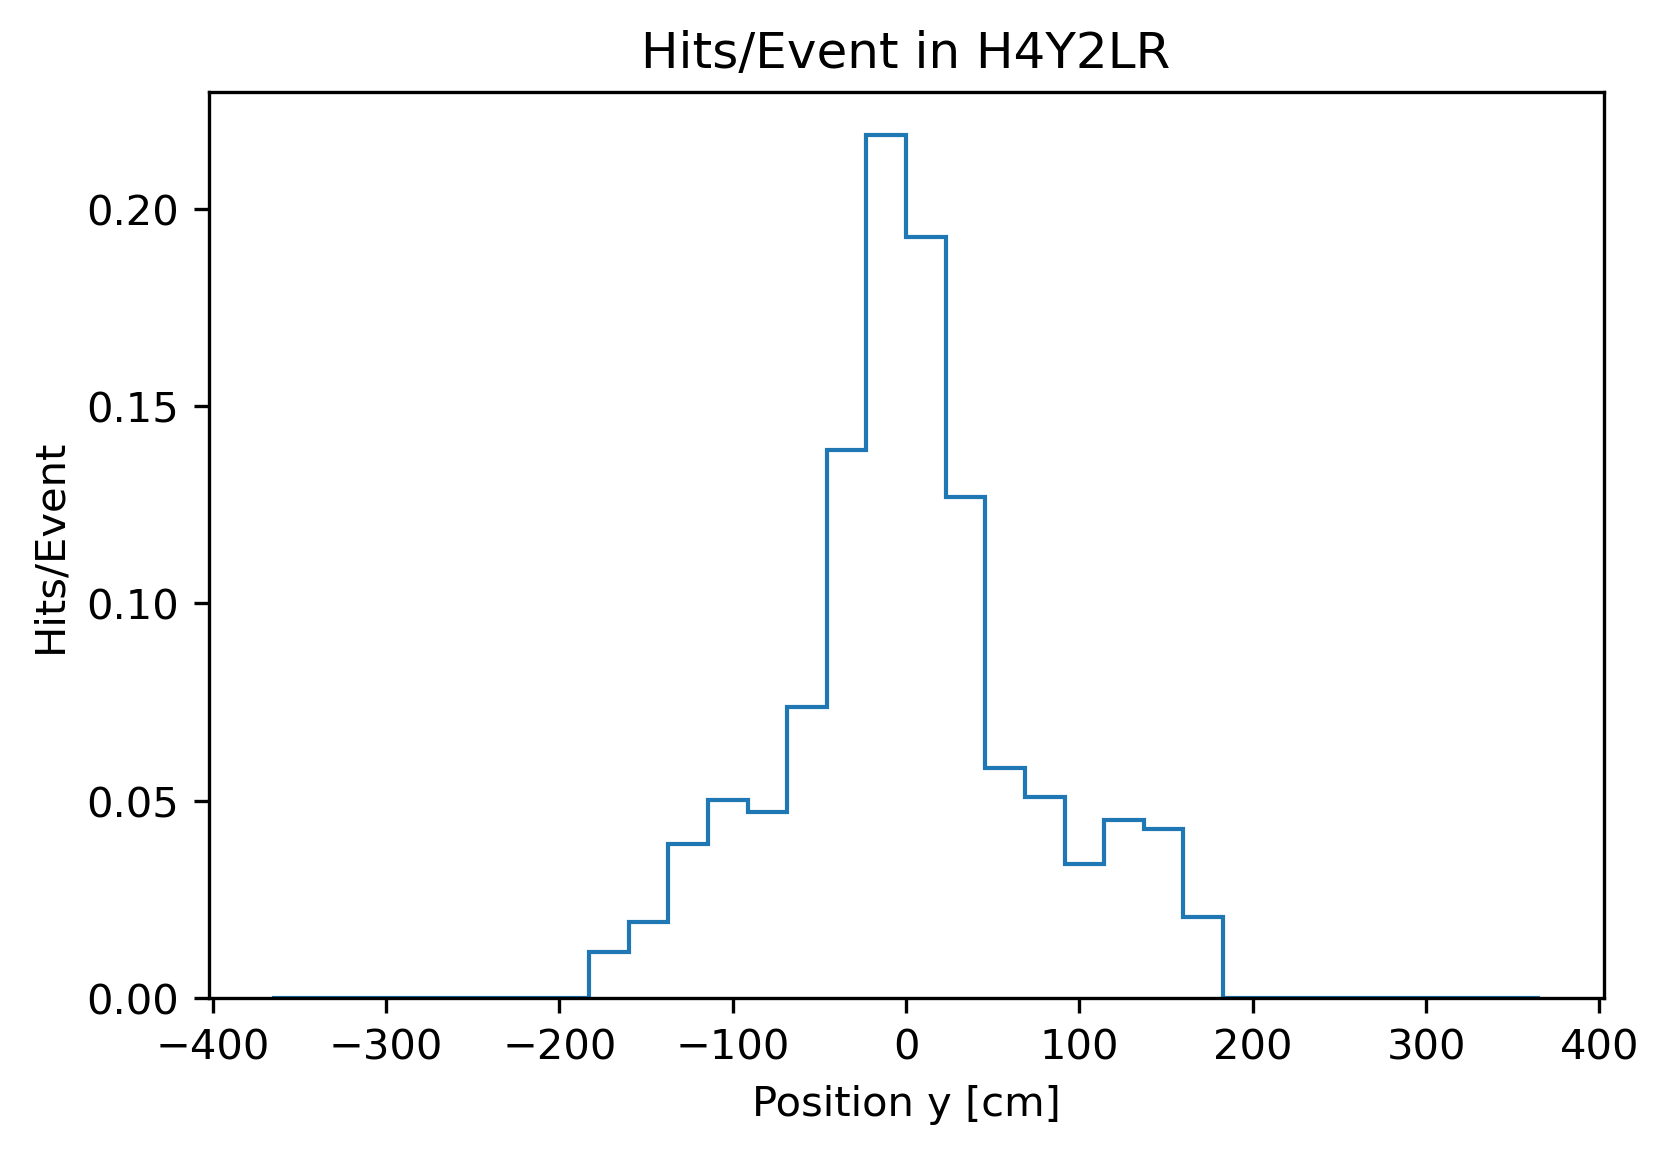

In [52]:
plotHodos(root, pos1=-14.64, pos2=14.64)

**This looks like it works**

# Now let us overlay with the original, uncut data

Original data:

In [68]:
# select detector
def detectorRange(arr, detid1, detid2):
    mask = (arr.detectorID >= detid1)
    mask = mask & (arr.detectorID <= detid2) 
    return mask

def stationMask(arr, detid1, detid2, pos1=-25, pos2=25):
    '''
    Mask the hits based on detid and position to set flags
    the position range goes pos1 <= pos <= pos2 -> [pos1,pos2]
    ST1, ST2 use pos [-14,14] -> two panels on either side x=0
    ST3 uses pos [-15,15] -> one panel on either side x = 0
    '''
    # mask on detectorID
    mask = (arr.detectorID >= detid1) & (arr.detectorID <= detid2)
    # mask on position
    mask = mask & (arr.pos >= pos1)
    mask = mask & (arr.pos <= pos2)
    
    return mask
    
# build detector mask
def detectorMask(arr, level=1, pos1=-25, pos2=25):
    '''
    Mask based on detectorID (plotting all) or
    Mask based on detectorID and pos (for making cut criteria)
    0 = cut
    1 = all
    '''
    detmask = {}
    if (level == 1):   # get all detectors (used for plotting all)
        for key,item in detID_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = detectorRange(arr,det[0],det[1])
    elif (level == 0):   # get only BT detectors (used for selection criteria)
        for key,item in sel_dict.items():
            for keyd,det in item['det'].items():
                detmask[keyd] = stationMask(arr,det[0],det[1],pos1,pos2)
    else:
        print("invalid level")
    return detmask

detID_dict = {'BT':{'dir':'x',
                    'det':{'H1BT':[31,32],
                           'H2BT':[37,38],
                           'H3BT':[39,40],
                           'H4BT':[45,46]
                          }
                    },
              'LR':{'dir':'y',
                    'det':{'H1LR':[33,34],
                           'H2LR':[35,36],
                           'H4Y1LR':[41,42],
                           'H4Y2LR':[43,44]
                          }
                   }
             }

def get_data_2017(root):
    '''
    returns a list of histogram information
    '''
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    detmask = detectorMask(allhits,1)
    
    # hit/event rate acquired by dividing by nevents
    nevents = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))
    
    # store hists
    xs = []
    
    for dets,item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            maskedhits_det = maskedhits[detmask[det]]   # nested dictionaries
            numpos = ak.num(maskedhits_det.pos)
            
            xs.append(ak.flatten(maskedhits_det.pos))   # these will be plotted
            
    return xs, nevents

def get_data_cut_2017(root, pos1=-25, pos2=25):
    # mask w. triggerBits &(32|128) - Random trigger
    trigmask = (root.fTriggerBits == 67)
    trigmask = trigmask | (root.fTriggerBits == 65)
    
    # get and mask all hits
    allhits = root.fAllHits
    maskedhits = ak.mask(allhits,trigmask)
    
    # this is what is normally plotted
    detmask = detectorMask(allhits,1)   # pos1, pos2 not needed here
    
    # mask by station 1 criteria
    st1mask = detectorMask(allhits,0,pos1,pos2)

    # now get the indices
    indices = flag(st1mask)

    # number of valid events to loop thru after selecting for station 1 criteria
    nevents = len(indices)
    
    # weighing -> we weigh by the total number of hits given by triggerBits
    weight = len(ak.flatten(ak.count(maskedhits.pos,axis=-1),0))
    
    xs = []
    
    # plotting
    for dets, item in detID_dict.items():
        direction = item['dir']
        detectors = item['det']
        for det in detectors.keys():
            # hits masked by fTriggerBits 
            maskedhits_det = maskedhits[detmask[det]]

            # hold the positions of the valid events
            valid = np.array([])
            # keep track of the number of valid events (for weighing? - prob just use weight above)
            validEvents = 0
            for i in range(nevents):
                if maskedhits_det.pos[i] != None:
                    valid = np.append(valid, ak.to_numpy(maskedhits_det.pos[i]))
                    validEvents += 1
            
            xs.append(valid)
            
    return xs, weight

def combine_histogram(root, pos1, pos2, pos3, pos4):
    
    # constant for all data 
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-227.518,227.518), "H3BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    # get lists with histogram data
    og_data, og_nevents = get_data_2017(root)
    cut_data, cut_nevents = get_data_cut_2017(root,pos1,pos2)
    cut_data2, cut_nevents2 = get_data_cut_2017(root,pos3,pos4)
    
    for i in range(len(bins_range)):
        savename = "{}_2017_cut".format(bins_range[i][2])
        title = "Hits/Event in {}".format(bins_range[i][2])
        plt.clf()
        fig = plt.figure(dpi=300)
        
        '''og data'''
        og_ws = np.ones_like(ak.to_numpy(og_data[i]))/og_nevents
        if (i==3) or (i==6) or (i==7):
            og_ws /= 2
        plt.hist(og_data[i],bins=bins_range[i][0],range=bins_range[i][1],histtype='step',weights=og_ws,label="uncut")
        
        '''cut data 1'''
        cut_ws = np.ones_like(cut_data[i])/cut_nevents
        if (i==3) or (i==6) or (i==7):
            cut_ws /= 2
        plt.hist(cut_data[i],bins=bins_range[i][0],range=bins_range[i][1],histtype='step',weights=cut_ws,label="x=[{},{}]".format(pos1,pos2))
        
        '''cut data 2'''
        cut_ws2 = np.ones_like(cut_data2[i])/cut_nevents2
        if (i==3) or (i==6) or (i==7):
            cut_ws2 /= 2
        plt.hist(cut_data2[i],bins=bins_range[i][0],range=bins_range[i][1],histtype='step',weights=cut_ws2,label="x=[{},{}]".format(pos3,pos4)) 
        
        '''label'''
        plt.ylabel("Hits/Event")
        if (i<4):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.title(title)
        plt.legend(prop={'size':10})
        plt.savefig(savename)
        plt.show()
            


<Figure size 432x288 with 0 Axes>

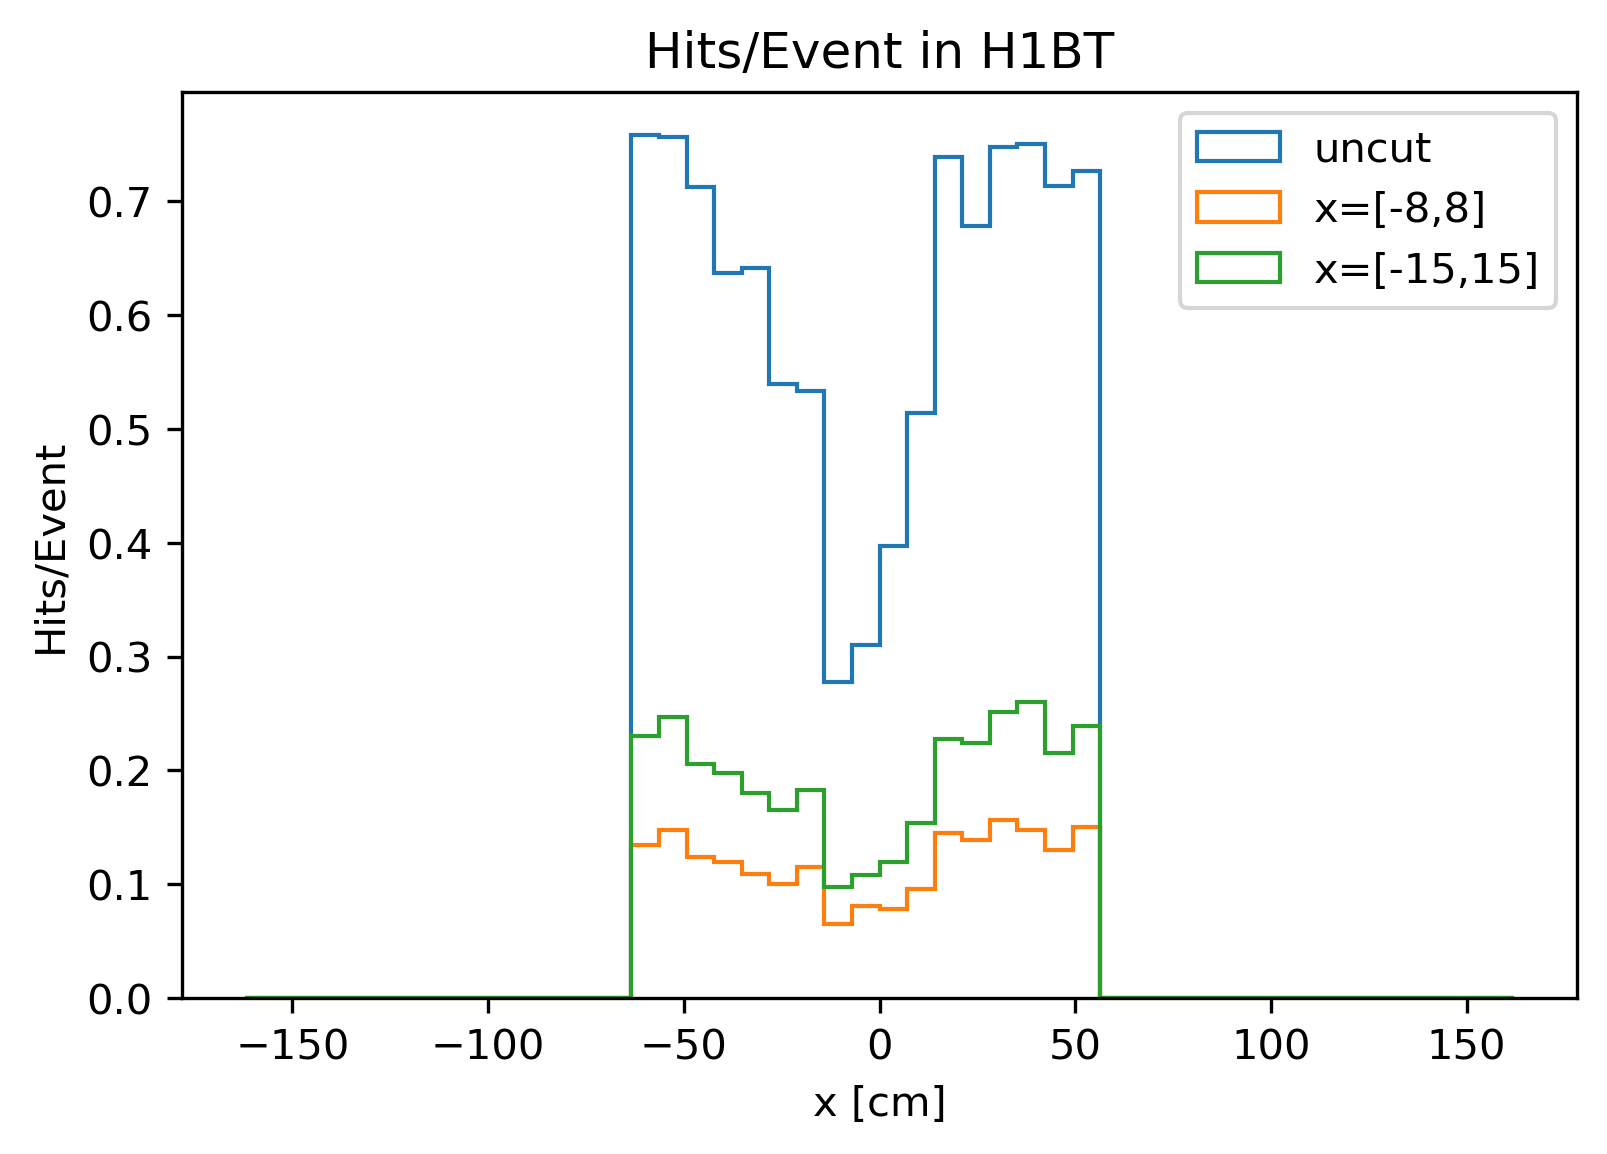

<Figure size 432x288 with 0 Axes>

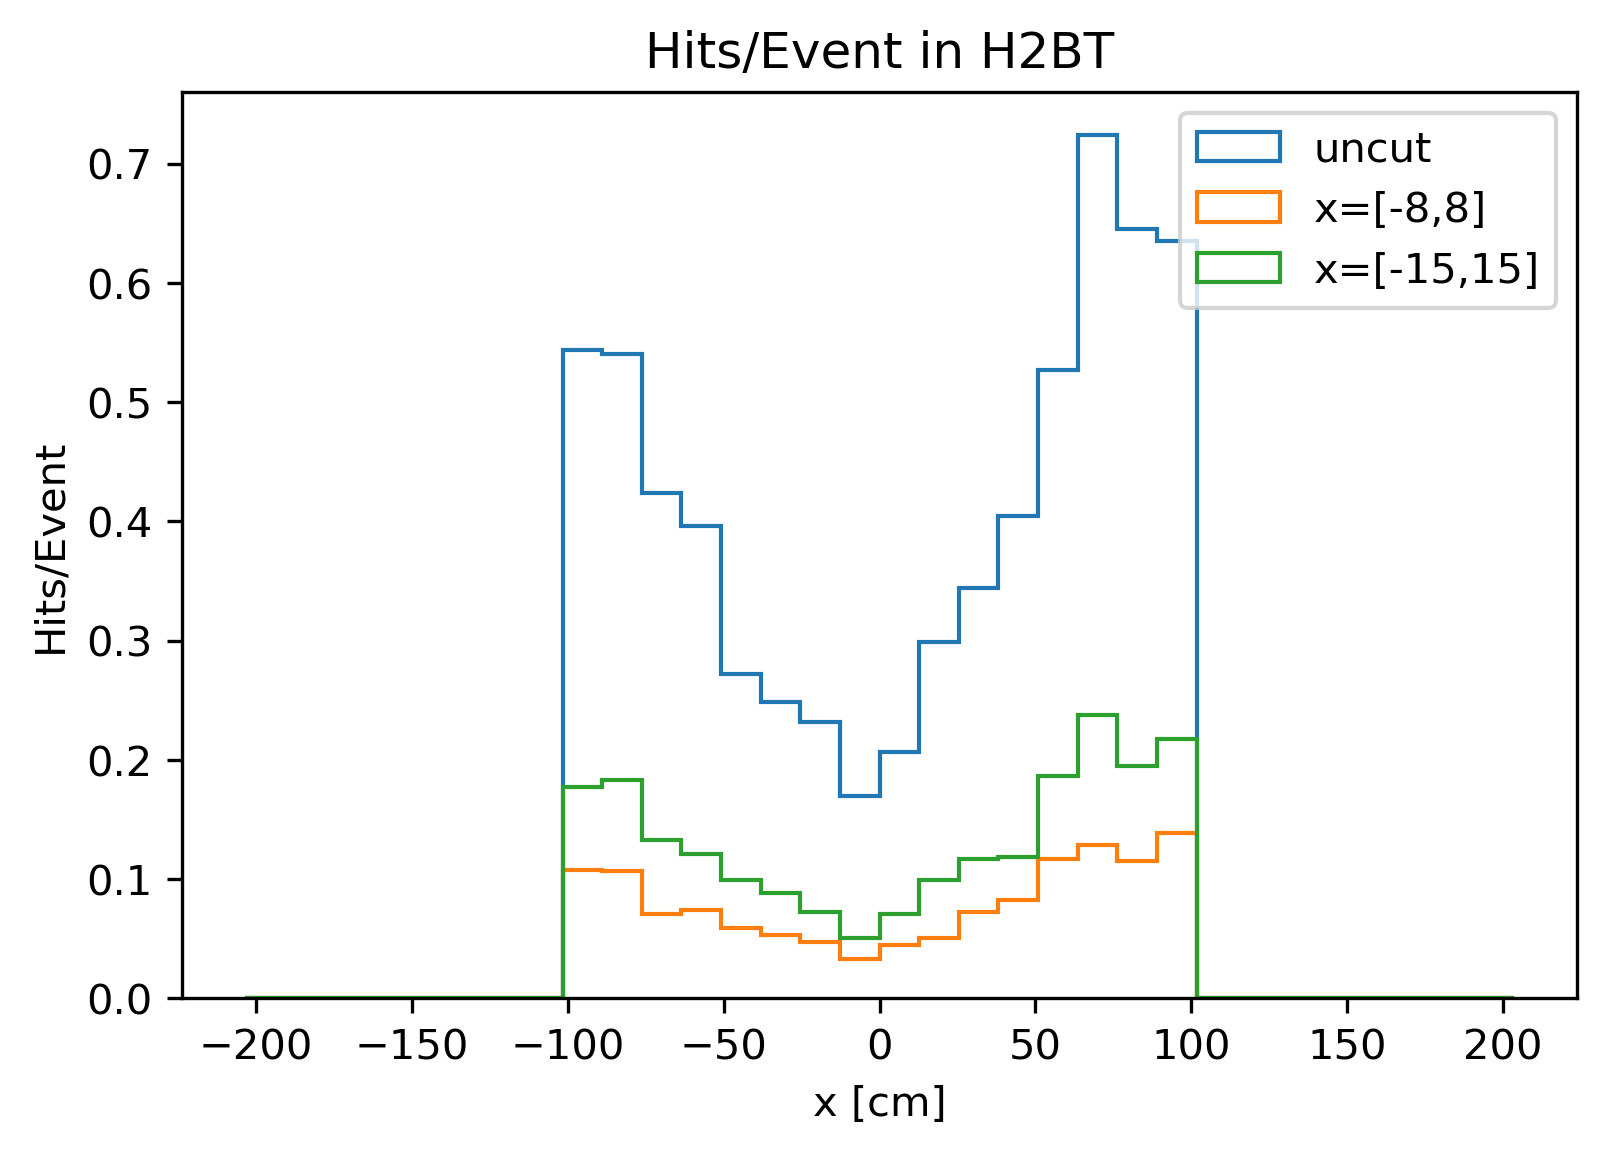

<Figure size 432x288 with 0 Axes>

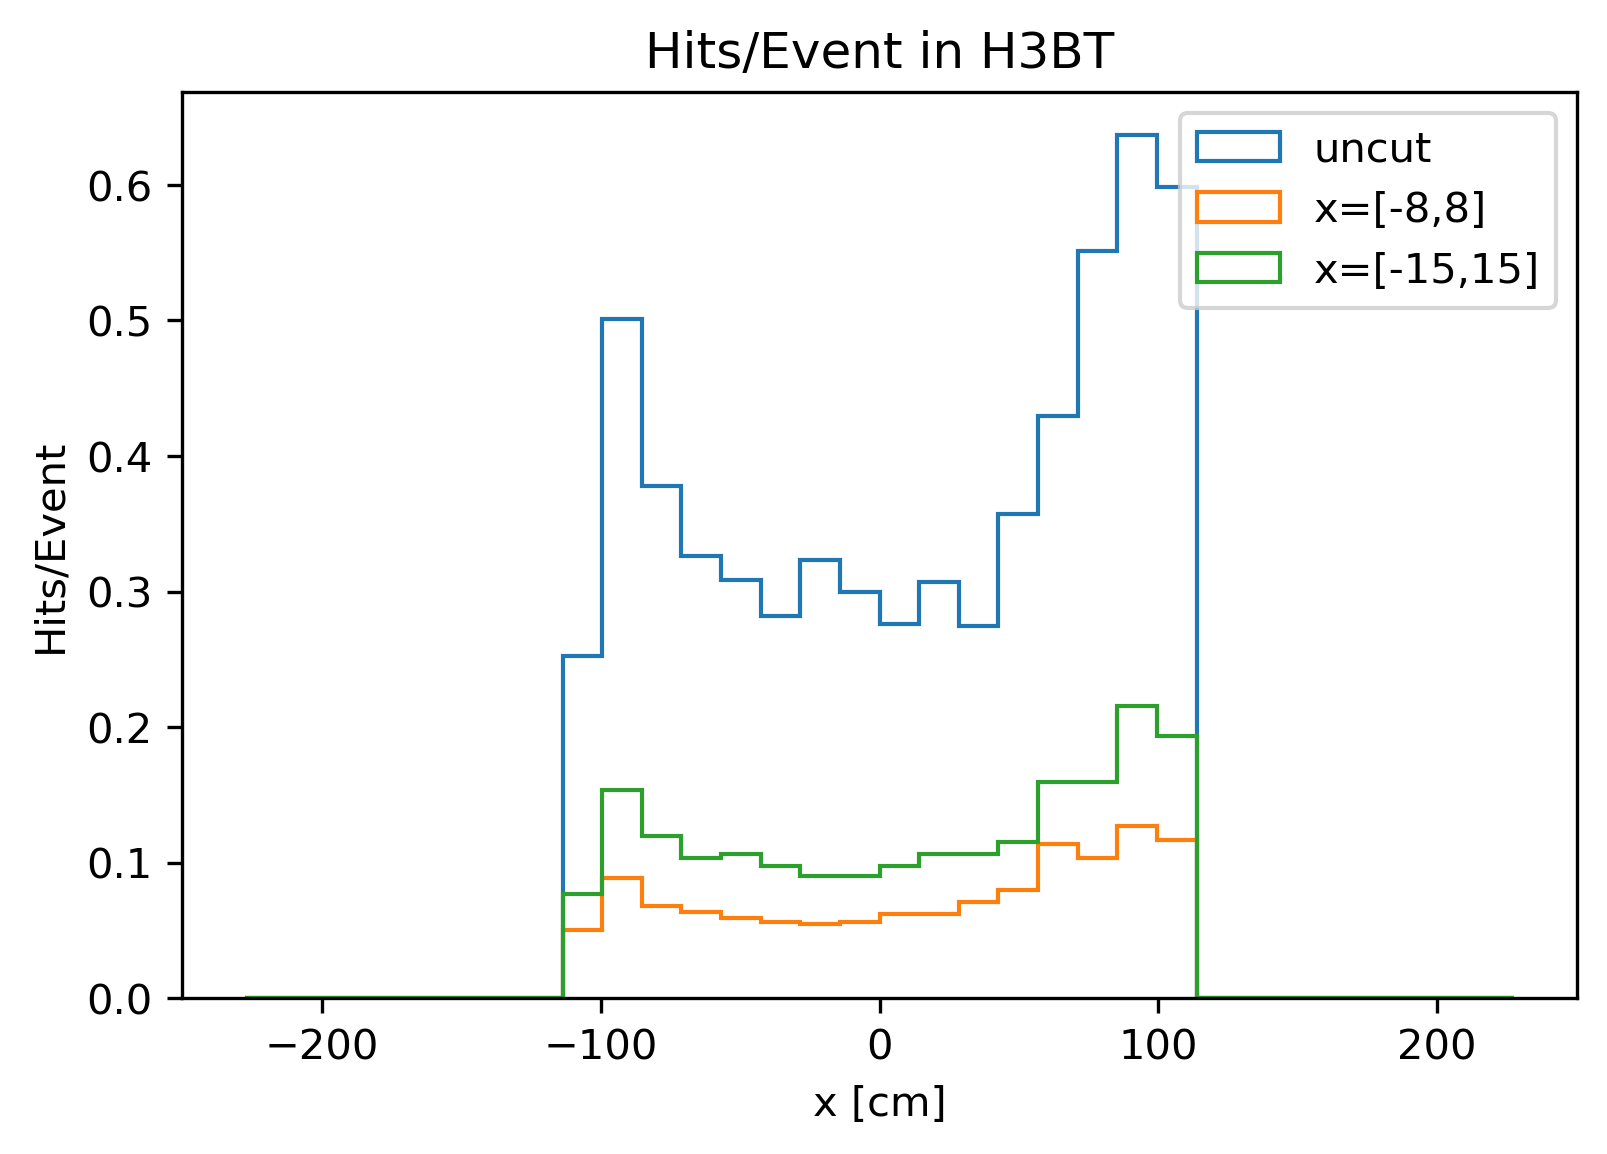

<Figure size 432x288 with 0 Axes>

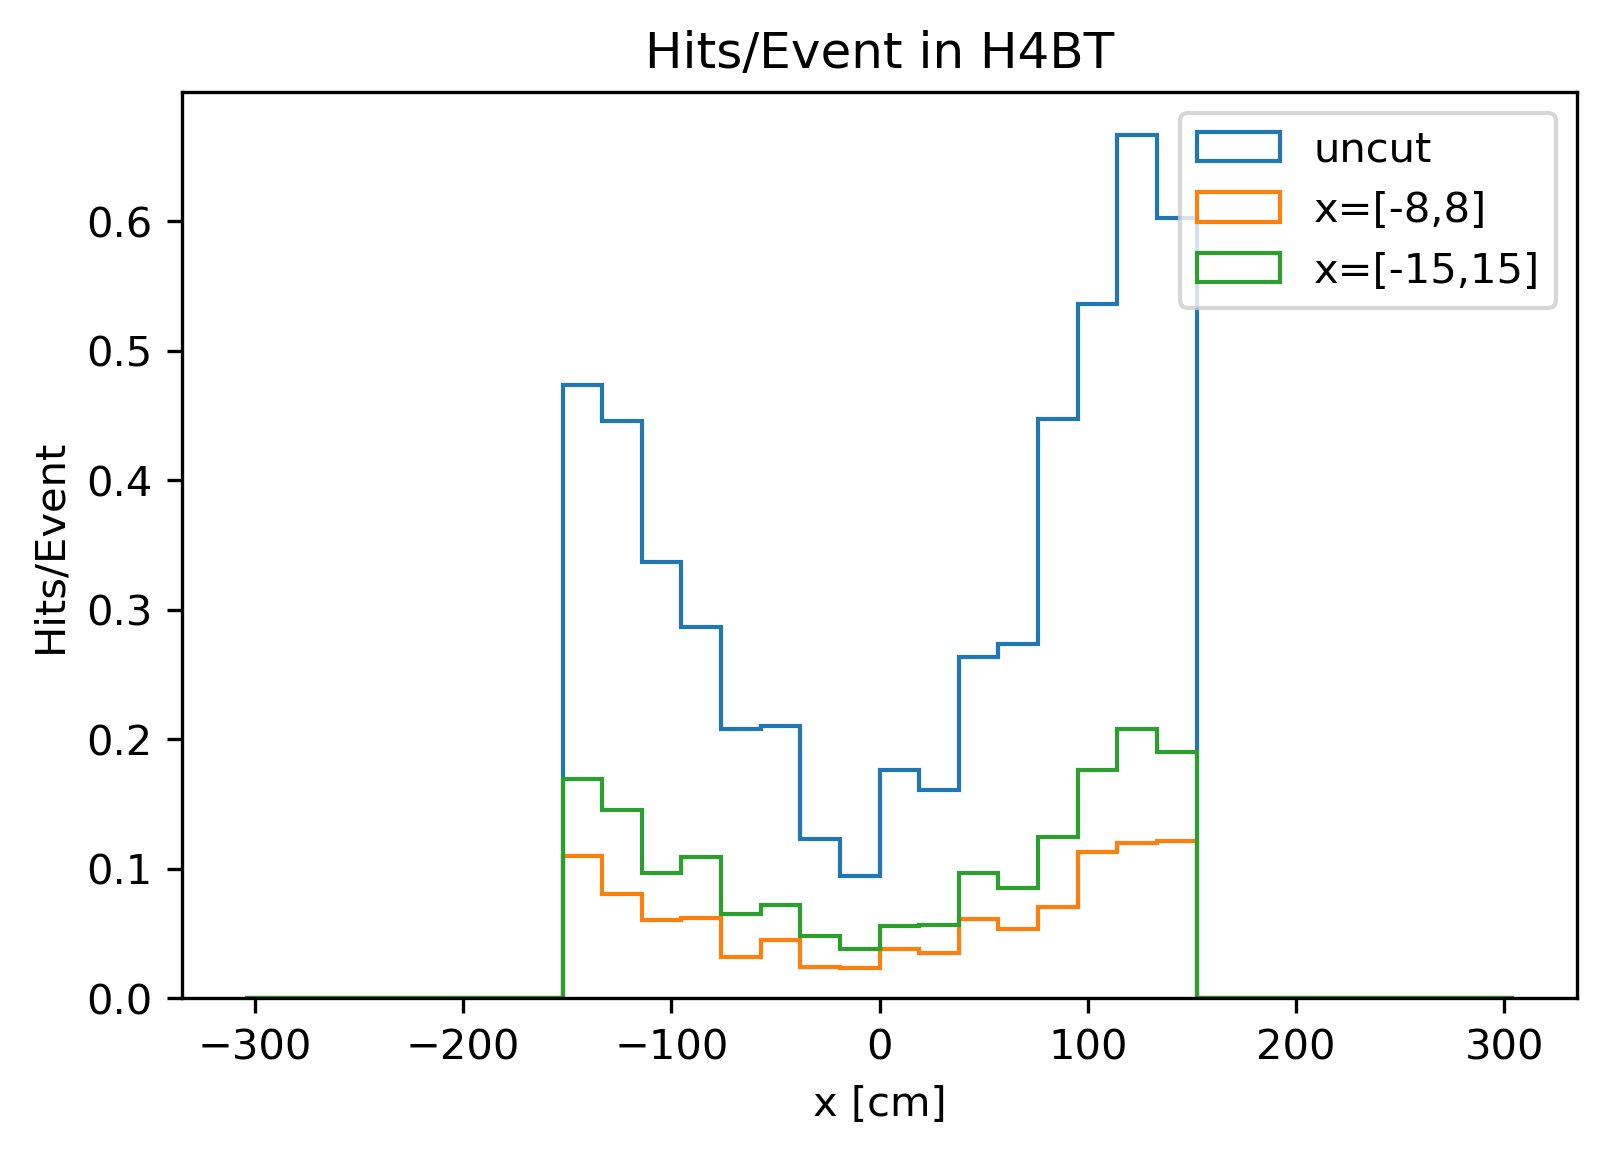

<Figure size 432x288 with 0 Axes>

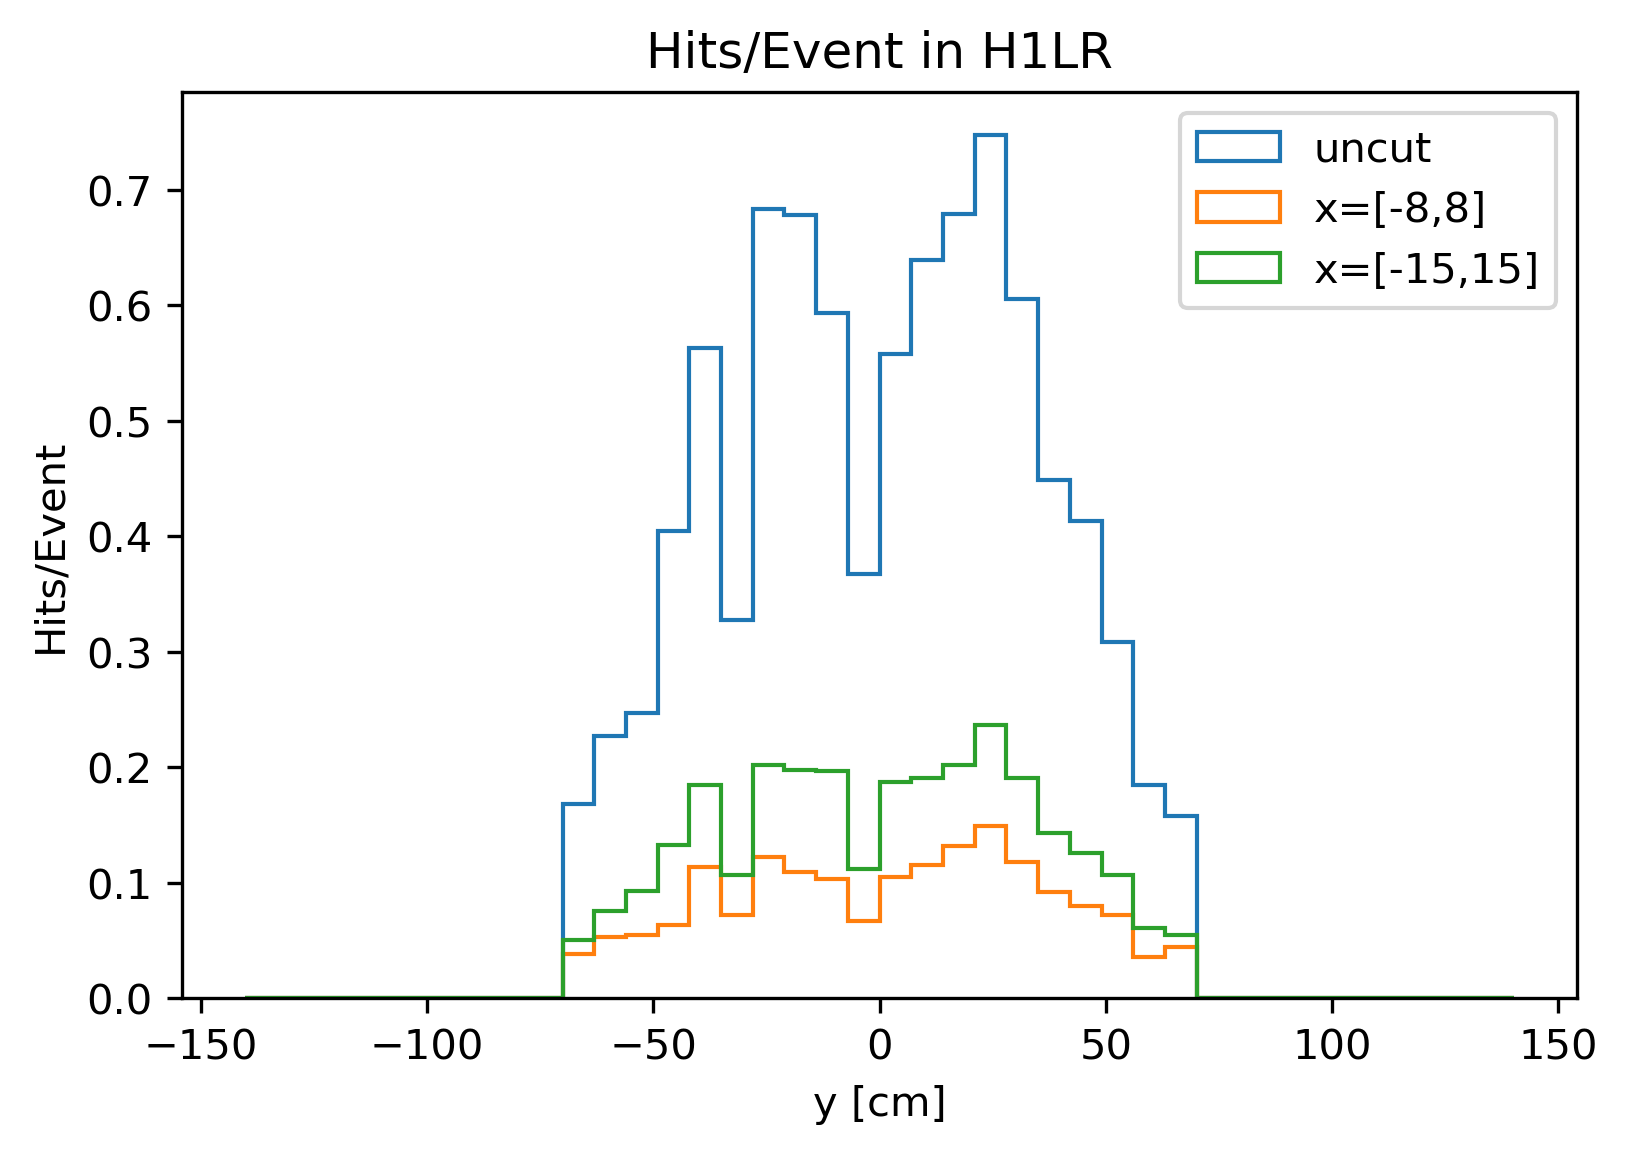

<Figure size 432x288 with 0 Axes>

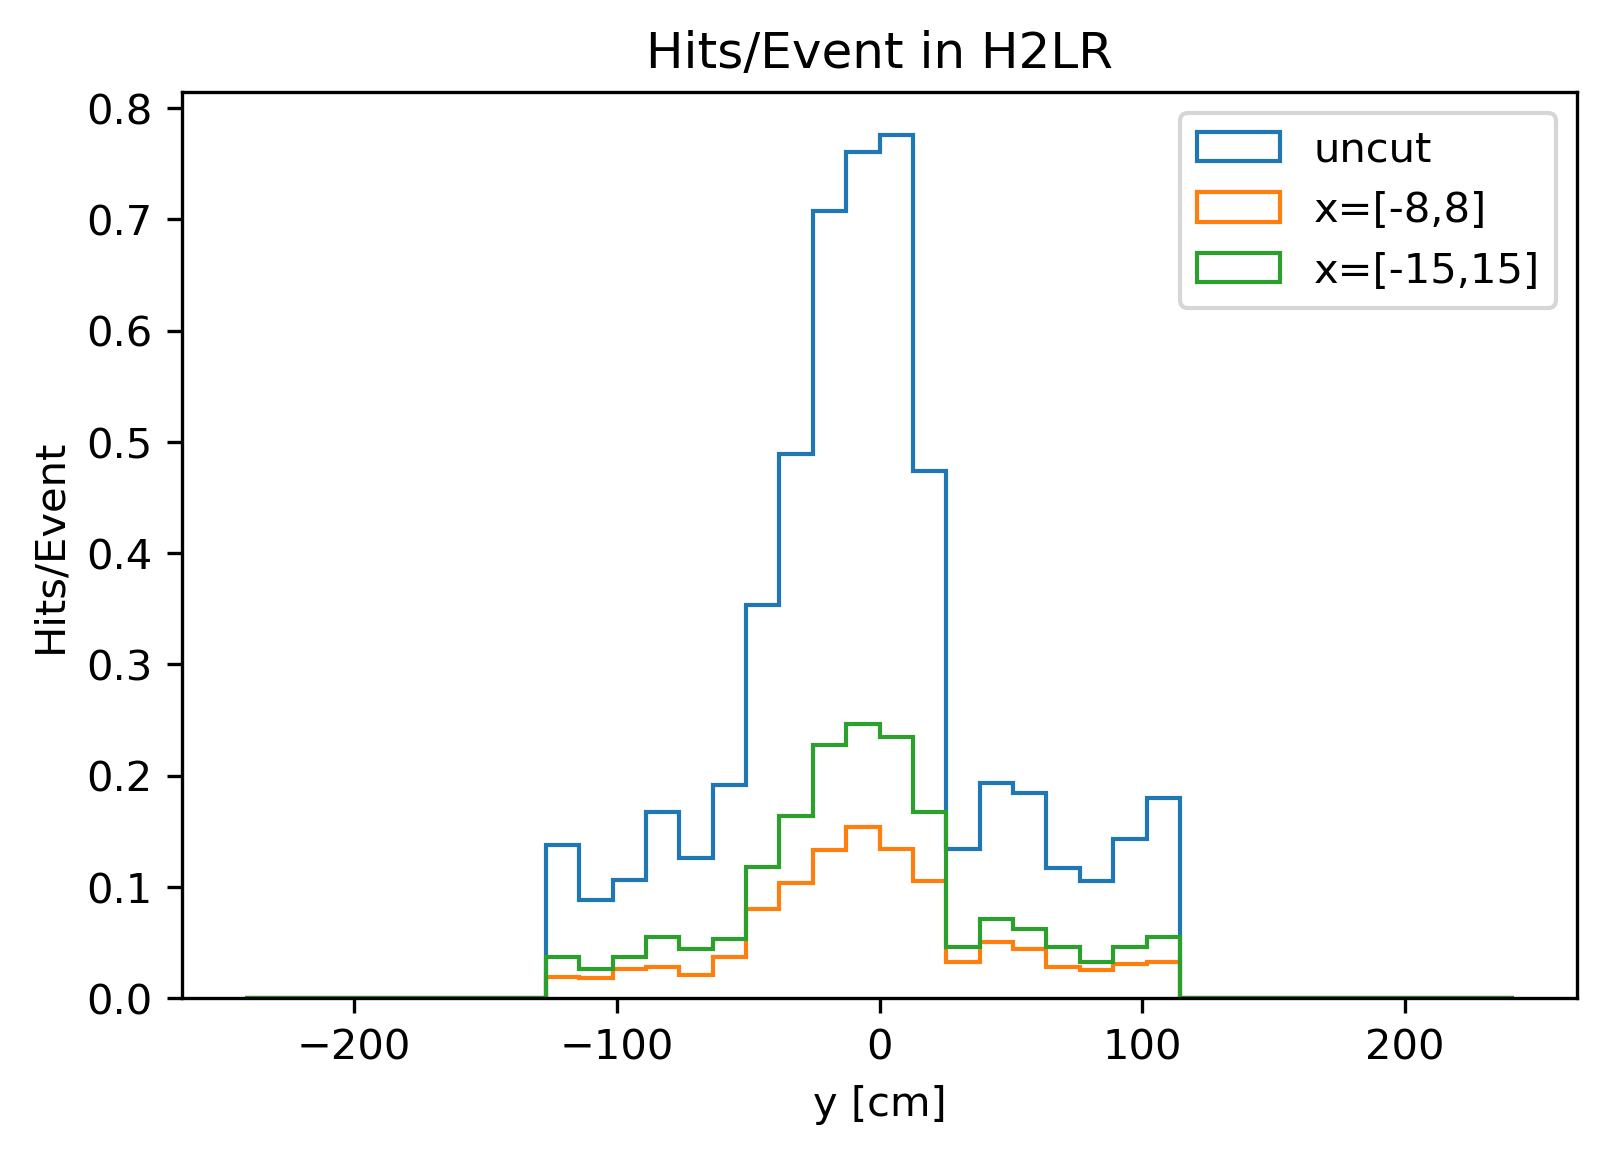

<Figure size 432x288 with 0 Axes>

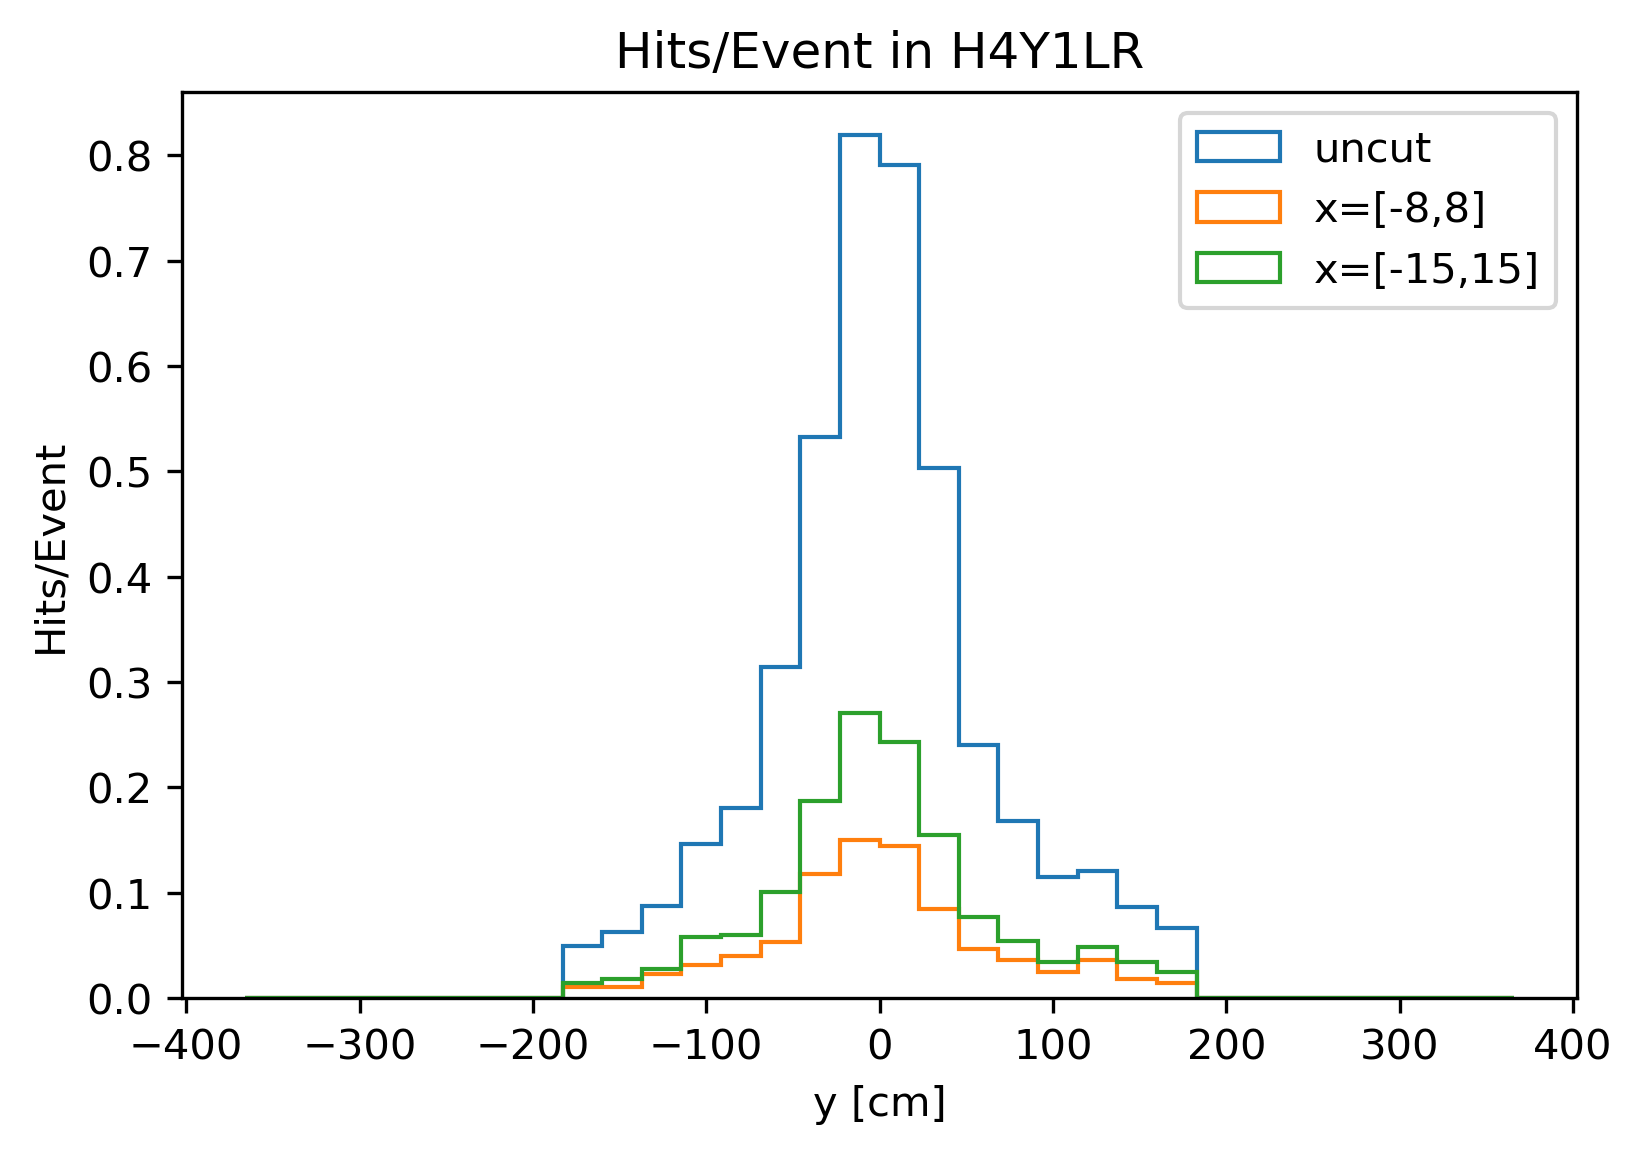

<Figure size 432x288 with 0 Axes>

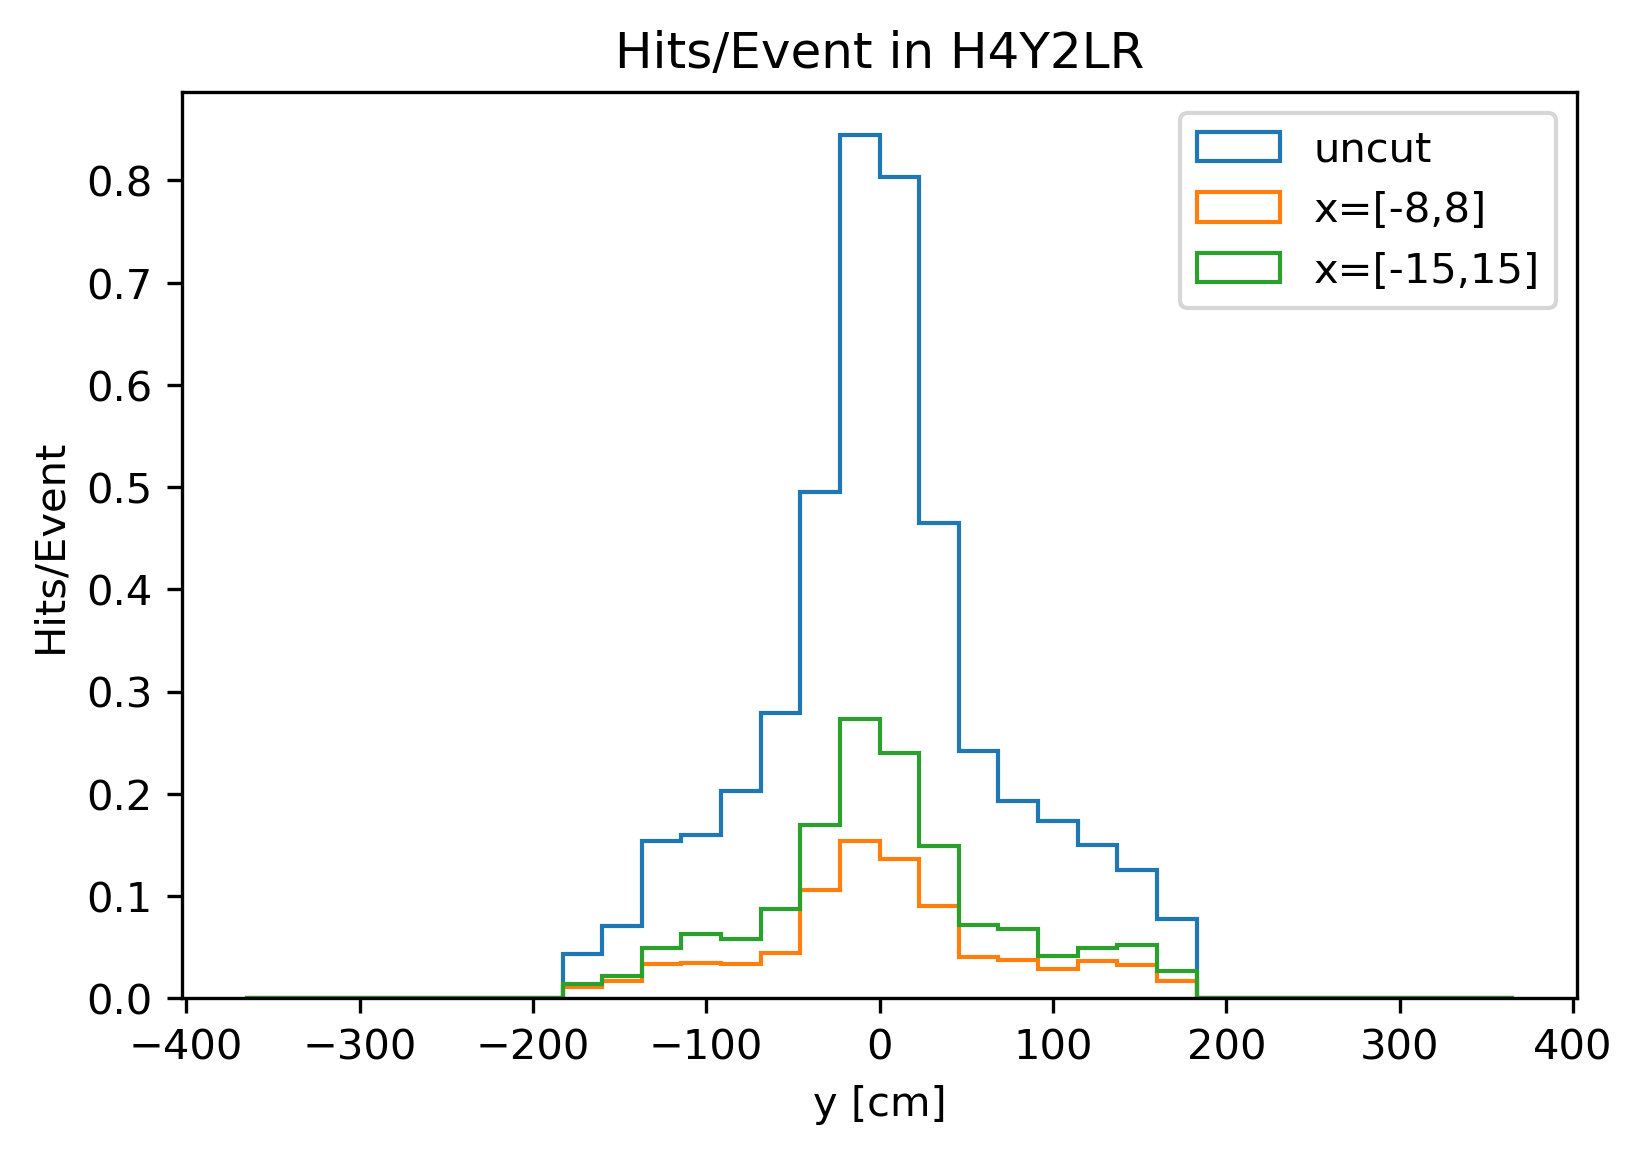

In [69]:
combine_histogram(root,-8,8,-15,15)